# Price Optimization for an E-Commerce Store

### About the Company -
A clothing company specializes in a diverse range of apparel and accessories. The company operates both physical stores and an online e-commerce platform. The company aims to enhance its revenue and market competitiveness by optimizing its pricing strategy.

### Challenges Faces by the Company - 
The clothing and apparel company encounters various challenges in effectively pricing its products.

<b>Competitive Landscape:</b> The retail industry is fiercely competitive, with numerous rivals offering similar products. The company seeks to differentiate itself by providing appealing prices while maintaining profitability.<br>
<b>Inventory Management:</b> Effective inventory management is crucial for the company, requiring pricing strategies that balance supply and demand. Optimization based on inventory levels helps prevent overstocking or understocking of products.<br>
<b>Seasonal and Trend Variations:</b> Rapid changes in fashion trends and fluctuating demand throughout the year pose challenges for the company. Adapting prices to reflect seasonal and trend variations is essential to capitalize on sales opportunities.

### Proposed Solution
The company has identified a need for a sound strategy for price optimization of products.

<h3>Dataset Description</h3>
<p>The data contains information on demand and corresponding average unit price at a <strong>product-month_year level</strong>.</p>

<ul>
  <li><strong>product_id</strong>: A unique identifier for each product in the dataset.</li>
  <li><strong>product_category_name</strong>: The name of the product category to which the product belongs.</li>
  <li><strong>month_year</strong>: The month and year of the retail transaction or data recording.</li>
  <li><strong>qty</strong>: The quantity of the product sold or purchased in a given transaction.</li>
  <li><strong>total_price</strong>: The total price of the product, including any applicable taxes or discounts. Calculated using qty * unit_price.</li>
  <li><strong>freight_price</strong>: The average freight price associated with the product.</li>
  <li><strong>unit_price</strong>: The average unit price of a single unit of the product.</li>
  <li><strong>product_name_length</strong>: The length of the product name in terms of the number of characters.</li>
  <li><strong>product_description_length</strong>: The length of the product description in terms of the number of characters.</li>
  <li><strong>product_photos_qty</strong>: The number of photos available for the product in the dataset.</li>
  <li><strong>product_weight_g</strong>: The weight of the product in grams.</li>
  <li><strong>product_score</strong>: Average product rating associated with the product’s quality, popularity, or other relevant factors.</li>
  <li><strong>customers</strong>: The number of customers who purchased the product in a given category.</li>
  <li><strong>weekday</strong>: Number of weekdays in that month.</li>
  <li><strong>weekend</strong>: Number of weekends in that month.</li>
  <li><strong>holiday</strong>: Number of holidays in that month.</li>
  <li><strong>month</strong>: The month in which the transaction occurred.</li>
  <li><strong>year</strong>: The year in which the transaction occurred.</li>
  <li><strong>s</strong>: The effect of seasonality.</li>
  <li><strong>Volume</strong>: Product Volume.</li>
  <li><strong>Comp_1</strong>: Competitor1 price.</li>
  <li><strong>Ps1</strong>: Competitor1 product rating.</li>
  <li><strong>Fp1</strong>: Competitor1 freight price.</li>
  <li><strong>Comp_2</strong>: Competitor2 price.</li>
  <li><strong>Ps2</strong>: Competitor2 product rating.</li>
  <li><strong>Fp2</strong>: Competitor2 freight price.</li>
  <li><strong>Comp_3</strong>: Competitor3 price.</li>
  <li><strong>Ps3</strong>: Competitor3 product rating.</li>
  <li><strong>Fp3</strong>: Competitor3 freight price.</li>
  <li><strong>Lag_price</strong>: Previous month's price of the product.</li>
</ul>

### Importing Libraries and Loading the Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway, kruskal, ttest_ind, chi2_contingency, shapiro, ks_2samp, boxcox
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style='darkgrid', palette='deep')
pd.set_option('display.max_columns', None) 

### Utility Functions

In [2]:
def outlier_report(data, cols):

    """
    Utility Function to return a report of outliers
    Inputs:
        data: dataframe
        cols: List of columns that are to be part of the report
    Output:
        Contains the column name, Number of Outliers detected in the column and Percentage of Outliers
    """
    
    npts = data.shape[0]
    print("******************* Outlier Report *******************\n")
    for col in cols:
        # Calculate the IQR
        first_quartile = np.percentile(data[col], 25)
        third_quartile = np.percentile(data[col], 75)
        iqr = third_quartile - first_quartile

        # Calculate upper and lower bounds based on the 1.5x IQR rule
        ub = third_quartile + (iqr * 1.5)
        lb = first_quartile - (iqr * 1.5)

        num_outliers = data[(data[col] > ub) | (data[col] < lb)].shape[0]
        outlier_perc = np.round((num_outliers / npts) * 100, 2)

        print(f"Column: {col}, Number of Outliers: {num_outliers}, Percentage of Outliers: {outlier_perc}%\n")
    print("******************************************************")


def treat_outliers(data, col, multiplier=1.5):

    """
    Utility Function to return treat outliers based on the IQR rule
    Inputs:
        data: dataframe
        col: Column to be treated
        multiplier: mutltiplier to be used for IQR capping (1.5 or 3)
    Output:
        Returns the treated values
    """

    col_values = data[col]

    # Calculate the 25th and 75th percentiles 
    first_quartile = np.percentile(data[col], 25)
    third_quartile = np.percentile(data[col], 75)

    # Calculate the IQR
    iqr = third_quartile - first_quartile

    # Calculate range 
    ub = third_quartile + (multiplier * iqr)
    lb = first_quartile - (multiplier * iqr)

    # Treat the outliers
    col_values = np.where(col_values > ub, ub, col_values)
    col_values = np.where(col_values < lb, lb, col_values)
    
    return col_values

def vif_report(X_train):

    """Takes in the X_train dataframe and prints the VIF report"""
    
    vif = pd.DataFrame()
    X_t = pd.DataFrame(X_train, columns=X_train.columns)
    vif['Features'] = X_t.columns
    vif['VIF'] = [variance_inflation_factor(X_t.values, i) for i in range(X_t.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)

    return vif


def evaluate_model(X_train, X_test, y_train, y_test, model):

    """
    Function to return print a evaluation report of the model
    Inputs:
        X_train: Training data
        X_test: Testing data
        y_train: training labels
        y_test: testing labels
        model: Trained model
    Output:
        Returns the R2 and Adjusted R2 scores for both Train and Test datasets
    """
    
    # Get model Predictions
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    # Evaluate the model
    r2_train_score = r2_score(y_train, train_preds)
    r2_test_score = r2_score(y_test, test_preds)

    # Caluclating Adjusted R squared -> 1 - ((1 - R2) * (N-1) / (N - K - 1))
    n_train = X_train.shape[0]
    n_test = X_test.shape[0]
    k = len(X_train.columns)
    adj_r2_train_score = 1 - ((1 - r2_train_score) * (n_train - 1)) / (n_train - k - 1)
    adj_r2_test_score = 1 - ((1 - r2_test_score) * (n_test - 1)) / (n_test - k - 1)

    print(f"Train R2 Score: {r2_train_score}, Train Adjusted R2 Score: {adj_r2_train_score}")
    print(f"Test R2 Score: {r2_test_score}, Test Adjusted R2 Score: {adj_r2_test_score}")

In [3]:
# Read the dataset
df = pd.read_csv('price_optimsation_dataset.csv')

In [4]:
df.shape

(676, 30)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 676 entries, 0 to 675
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  676 non-null    object 
 1   product_category_name       676 non-null    object 
 2   month_year                  676 non-null    object 
 3   qty                         676 non-null    int64  
 4   total_price                 676 non-null    float64
 5   freight_price               676 non-null    float64
 6   unit_price                  676 non-null    float64
 7   product_name_lenght         676 non-null    int64  
 8   product_description_lenght  676 non-null    int64  
 9   product_photos_qty          676 non-null    int64  
 10  product_weight_g            676 non-null    int64  
 11  product_score               676 non-null    float64
 12  customers                   676 non-null    int64  
 13  weekday                     676 non

In [6]:
# Converting the month_year column to a datetime column
df['month_year'] = pd.to_datetime(df['month_year'])

In [7]:
df.head()

,product_id,product_category_name,month_year,qty,total_price,freight_price,unit_price,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_score,customers,weekday,weekend,holiday,month,year,s,volume,comp_1,ps1,fp1,comp_2,ps2,fp2,comp_3,ps3,fp3,lag_price
0,bed1,bed_bath_table,2017-01-05,1,45.95,15.100000,45.95,39,161,2,350,4.0,57,23,8,1,5,2017,10.267394,3800,89.9,3.9,15.011897,215.000000,4.4,8.760000,45.95,4.0,15.100000,45.90
1,bed1,bed_bath_table,2017-01-06,3,137.85,12.933333,45.95,39,161,2,350,4.0,61,22,8,1,6,2017,6.503115,3800,89.9,3.9,14.769216,209.000000,4.4,21.322000,45.95,4.0,12.933333,45.95
2,bed1,bed_bath_table,2017-01-07,6,275.70,14.840000,45.95,39,161,2,350,4.0,123,21,10,1,7,2017,12.071651,3800,89.9,3.9,13.993833,205.000000,4.4,22.195932,45.95,4.0,14.840000,45.95
3,bed1,bed_bath_table,2017-01-08,4,183.80,14.287500,45.95,39,161,2,350,4.0,90,23,8,1,8,2017,9.293873,3800,89.9,3.9,14.656757,199.509804,4.4,19.412885,45.95,4.0,14.287500,45.95
4,bed1,bed_bath_table,2017-01-09,2,91.90,15.100000,45.95,39,161,2,350,4.0,54,21,9,1,9,2017,5.555556,3800,89.9,3.9,18.776522,163.398710,4.4,24.324687,45.95,4.0,15.100000,45.95


In [8]:
# Checking if there are any duplicates
df[['product_id','month_year']].drop_duplicates().shape

(676, 2)

In [9]:
# Range of data
df['month_year'].describe()

count                              676
mean     2017-07-16 20:54:40.473372928
min                2017-01-01 00:00:00
25%                2017-01-09 00:00:00
50%                2018-01-01 00:00:00
75%                2018-01-04 00:00:00
max                2018-01-08 00:00:00
Name: month_year, dtype: object

In [10]:
# Picking a single product to study the granularity level of the data
df[df['product_id'] == 'bed1'].sort_values(by='month_year').head(10)

,product_id,product_category_name,month_year,qty,total_price,freight_price,unit_price,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_score,customers,weekday,weekend,holiday,month,year,s,volume,comp_1,ps1,fp1,comp_2,ps2,fp2,comp_3,ps3,fp3,lag_price
0,bed1,bed_bath_table,2017-01-05,1,45.95,15.100000,45.950000,39,161,2,350,4.0,57,23,8,1,5,2017,10.267394,3800,89.900000,3.9,15.011897,215.000000,4.4,8.760000,45.950000,4.0,15.100000,45.900000
1,bed1,bed_bath_table,2017-01-06,3,137.85,12.933333,45.950000,39,161,2,350,4.0,61,22,8,1,6,2017,6.503115,3800,89.900000,3.9,14.769216,209.000000,4.4,21.322000,45.950000,4.0,12.933333,45.950000
2,bed1,bed_bath_table,2017-01-07,6,275.70,14.840000,45.950000,39,161,2,350,4.0,123,21,10,1,7,2017,12.071651,3800,89.900000,3.9,13.993833,205.000000,4.4,22.195932,45.950000,4.0,14.840000,45.950000
3,bed1,bed_bath_table,2017-01-08,4,183.80,14.287500,45.950000,39,161,2,350,4.0,90,23,8,1,8,2017,9.293873,3800,89.900000,3.9,14.656757,199.509804,4.4,19.412885,45.950000,4.0,14.287500,45.950000
4,bed1,bed_bath_table,2017-01-09,2,91.90,15.100000,45.950000,39,161,2,350,4.0,54,21,9,1,9,2017,5.555556,3800,89.900000,3.9,18.776522,163.398710,4.4,24.324687,45.950000,4.0,15.100000,45.950000
5,bed1,bed_bath_table,2017-01-10,3,137.85,15.100000,45.950000,39,161,2,350,4.0,50,22,9,2,10,2017,8.333333,3800,89.900000,3.9,21.572143,45.950000,4.0,15.100000,45.950000,4.0,15.100000,45.950000
6,bed1,bed_bath_table,2017-01-11,11,445.85,15.832727,40.531818,39,161,2,350,4.0,97,22,8,4,11,2017,30.555556,3800,89.900000,3.9,16.294000,40.531818,4.0,15.832727,40.531818,4.0,15.832727,45.950000
7,bed1,bed_bath_table,2017-01-12,6,239.94,15.230000,39.990000,39,161,2,350,4.0,41,21,10,1,12,2017,16.666667,3800,88.488235,3.9,18.898333,39.990000,4.0,15.230000,39.990000,4.0,15.230000,40.531818
8,bed1,bed_bath_table,2018-01-01,19,759.81,16.533684,39.990000,39,161,2,350,4.0,62,23,8,2,1,2018,17.757009,3800,86.900000,3.9,19.383529,39.990000,4.0,16.533684,39.990000,4.0,16.533684,39.990000
9,bed1,bed_bath_table,2018-01-02,18,719.82,13.749444,39.990000,39,161,2,350,4.0,62,20,8,2,2,2018,16.822430,3800,86.900000,3.9,19.209091,39.990000,4.0,13.749444,39.990000,4.0,13.749444,39.990000


#### Observation:
1. There are 676 rows in the dataset and 30 columns
2. There are no missing values in the dataset
3. There are no duplicates in the dataset
4. The dataset has product prices at a year-and-month level. This means that each row corresponds to the details of a product for a month and year
5. The data spans across an entire year starting from Jan 2017, going uptill Jan 2018

## Data Exploration and Uni-variate Analysis

### Product ID
Product ID is the unique identifier for each product in the dataset.

In [11]:
df['product_id'].unique()

array(['bed1', 'garden5', 'consoles1', 'garden7', 'health9', 'cool4',
       'health3', 'perfumery1', 'cool5', 'health8', 'garden4',
       'computers5', 'garden10', 'computers6', 'health6', 'garden6',
       'health10', 'watches2', 'health1', 'garden8', 'garden9',
       'watches6', 'cool3', 'perfumery2', 'cool2', 'computers1',
       'consoles2', 'health5', 'watches8', 'furniture4', 'watches5',
       'health7', 'bed3', 'garden3', 'bed2', 'furniture3', 'watches4',
       'watches3', 'furniture2', 'garden2', 'furniture1', 'health2',
       'garden1', 'cool1', 'computers4', 'watches7', 'computers3',
       'health4', 'watches1', 'computers2', 'bed4', 'bed5'], dtype=object)

In [12]:
df['product_id'].nunique()

52

#### Observations:
* There are about 52 types of products for which we have the pricing data
* The E-Commerce company offers products such as beds, consoles, computers, perfumes, watches, furniture, etc.

### Product Category Name
Product Category Name is the name of the product category to which the product belongs

In [13]:
# Number of unique product categories
df['product_category_name'].nunique()

9

In [14]:
df['product_category_name'].unique()

array(['bed_bath_table', 'garden_tools', 'consoles_games',
       'health_beauty', 'cool_stuff', 'perfumery',
       'computers_accessories', 'watches_gifts', 'furniture_decor'],
      dtype=object)

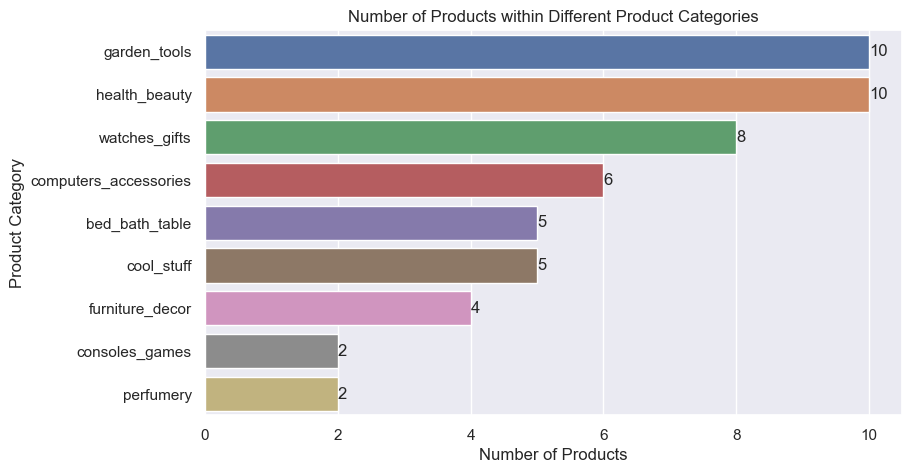

In [15]:
# Analyzing number of products per category

plt.figure(figsize=(9,5))
prod_grp_id = df.groupby(by=['product_category_name'])['product_id'].nunique().reset_index()
ax = sns.barplot(data=prod_grp_id, y='product_category_name', x='product_id', order=prod_grp_id.sort_values('product_id', ascending=False)['product_category_name'], palette='deep')
# Add bar labels to all bars
for container in ax.containers:
    ax.bar_label(container)
plt.title('Number of Products within Different Product Categories')
plt.xlabel('Number of Products')
plt.ylabel('Product Category')
plt.show()

#### Observations:
* The Product Categories range across 9 categories - Bed_Bath_Table, Garden_Tools, Console_Games, Health_Beauty, Cool_Stuff, Perfumery, Computer_Accessories, Watches_Gifts and Furniture_Decor
* Garden_Tools and Health_Beauty have the most number of products within them, both having 10 each
* Console Games and Perfumery have only 2 products each, which is the lowest across all the categories

### Product Quantity and Price Related Columns - Quantity, Total_price, Freight Price, Unit Price

In [16]:
df[['qty','total_price','freight_price','unit_price']].describe().T

,count,mean,std,min,25%,50%,75%,max
qty,676.0,14.495562,15.443421,1.0,4.000000,10.000000,18.000000,122.00
total_price,676.0,1422.708728,1700.123100,19.9,333.700000,807.890000,1887.322500,12095.00
freight_price,676.0,20.682270,10.081817,0.0,14.761912,17.518472,22.713558,79.76
unit_price,676.0,106.496800,76.182972,19.9,53.900000,89.900000,129.990000,364.00


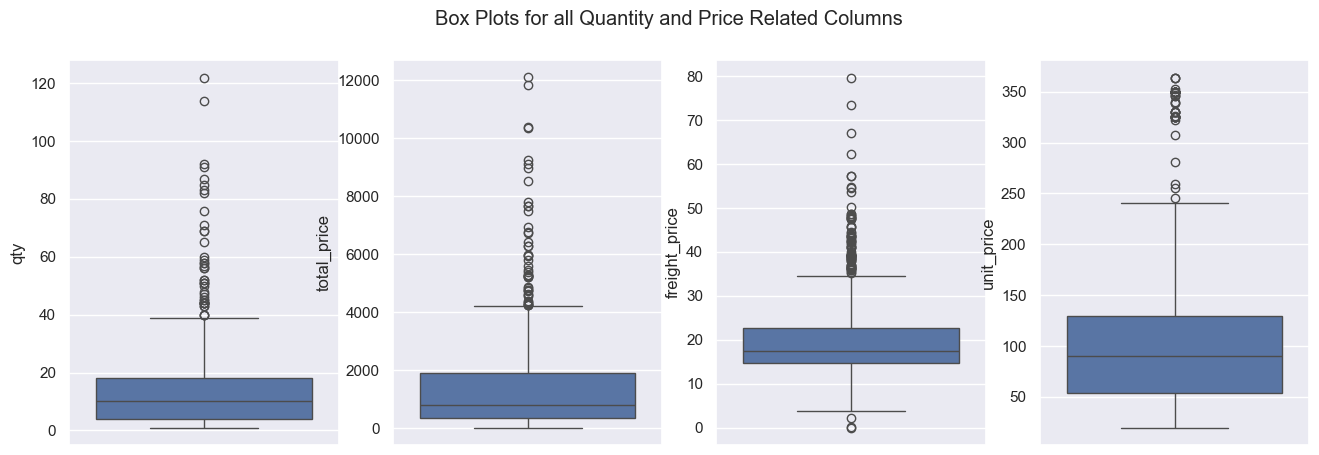

In [17]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=1, ncols=4, figsize=(16,5))

sns.boxplot(data=df, y='qty', ax=ax1)

sns.boxplot(data=df, y='total_price', ax=ax2)

sns.boxplot(data=df, y='freight_price', ax=ax3)

sns.boxplot(data=df, y='unit_price', ax=ax4)

plt.suptitle('Box Plots for all Quantity and Price Related Columns')
plt.show()

In [18]:
outlier_report(data=df, cols=['qty','total_price','freight_price','unit_price'])

******************* Outlier Report *******************

Column: qty, Number of Outliers: 42, Percentage of Outliers: 6.21%

Column: total_price, Number of Outliers: 46, Percentage of Outliers: 6.8%

Column: freight_price, Number of Outliers: 76, Percentage of Outliers: 11.24%

Column: unit_price, Number of Outliers: 45, Percentage of Outliers: 6.66%

******************************************************


In [19]:
# Treating the outliers 
cols_to_treat = ['qty','total_price','freight_price','unit_price']

for col in cols_to_treat:
    df[col] = treat_outliers(data=df, col=col,multiplier=1.5)

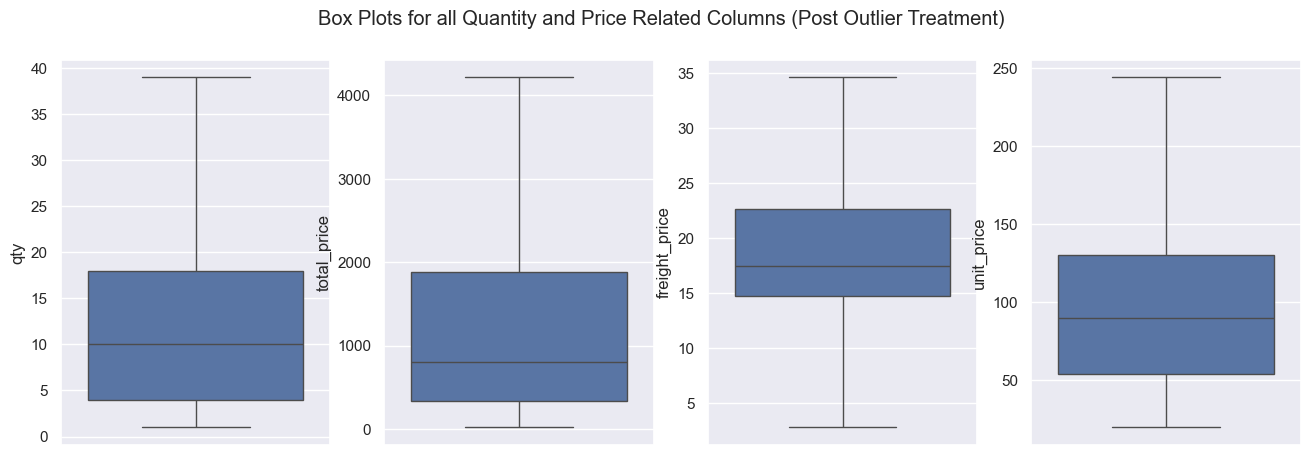

In [20]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=1, ncols=4, figsize=(16,5))

sns.boxplot(data=df, y='qty', ax=ax1)

sns.boxplot(data=df, y='total_price', ax=ax2)

sns.boxplot(data=df, y='freight_price', ax=ax3)

sns.boxplot(data=df, y='unit_price', ax=ax4)

plt.suptitle('Box Plots for all Quantity and Price Related Columns (Post Outlier Treatment)')
plt.show()

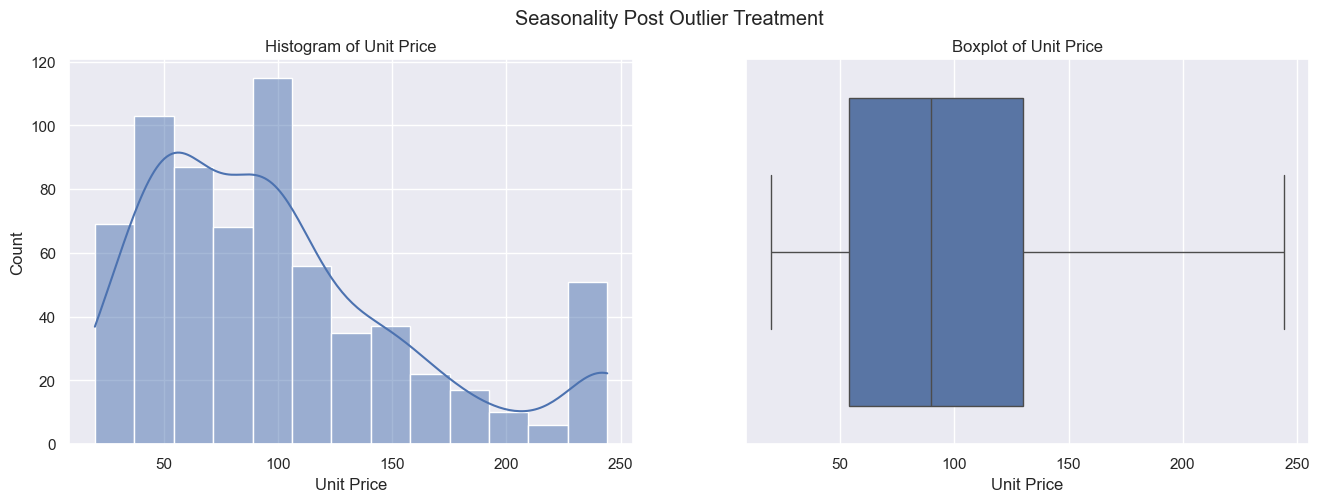

In [21]:
# Plotting histogram of Seasonality

fig, (ax1, ax2) =  plt.subplots(nrows=1, ncols=2, figsize=(16,5))

sns.histplot(df['unit_price'], kde=True, ax=ax1)
ax1.set_xlabel('Unit Price')
ax1.set_title('Histogram of Unit Price')

sns.boxplot(x=df['unit_price'], ax=ax2, whis=3.0)
ax2.set_xlabel('Unit Price')
ax2.set_title('Boxplot of Unit Price')

plt.suptitle('Seasonality Post Outlier Treatment')

plt.show()

#### Observations:
* Looking at the boxplots, we can see a fair number of outliers present in all the features
* As per the outlier report, the percentage of outliers across qty, total_price, freight_price and unit_price are 6.21%, 6.8%, 11.24% and 6.66% respectively
* These features have a right skewed distribution
* The outliers have been treated using the 1.5x IQR capping method

### Seasonality (s)

In [22]:
df['s'].head()

0    10.267394
1     6.503115
2    12.071651
3     9.293873
4     5.555556
Name: s, dtype: float64

In [23]:
df['s'].describe()

count    676.000000
mean      14.644970
std       11.930276
min        0.484262
25%        7.510204
50%       11.316760
75%       17.745704
max      100.000000
Name: s, dtype: float64

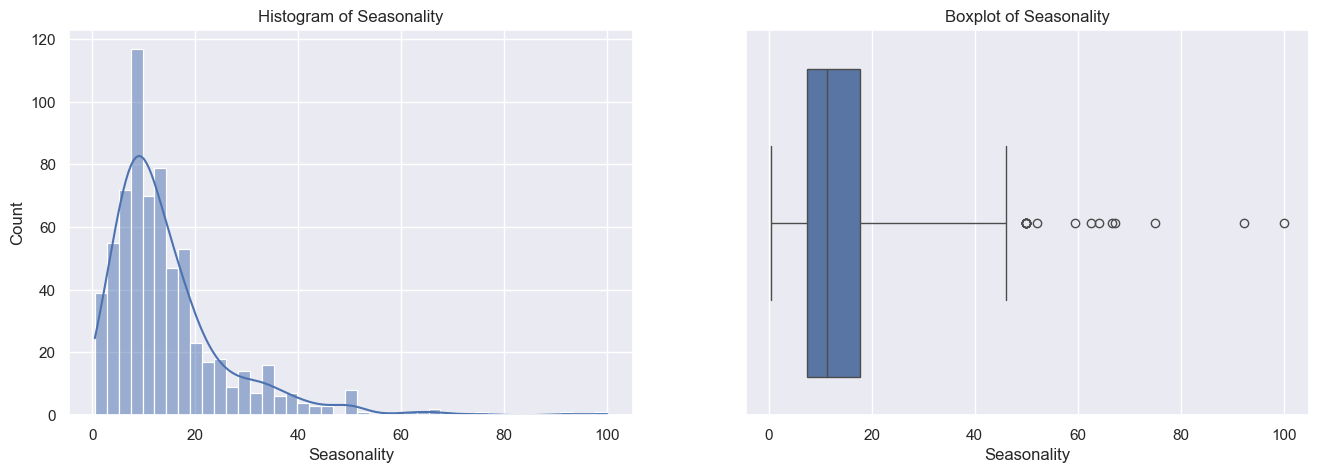

In [24]:
# Plotting histogram of Seasonality

fig, (ax1, ax2) =  plt.subplots(nrows=1, ncols=2, figsize=(16,5))

sns.histplot(df['s'], kde=True, ax=ax1)
ax1.set_xlabel('Seasonality')
ax1.set_title('Histogram of Seasonality')

sns.boxplot(x=df['s'], ax=ax2, whis=3.0)
ax2.set_xlabel('Seasonality')
ax2.set_title('Boxplot of Seasonality')

plt.show()

In [25]:
outlier_report(data=df, cols=['s'])

******************* Outlier Report *******************

Column: s, Number of Outliers: 53, Percentage of Outliers: 7.84%

******************************************************


In [26]:
df['s'] = treat_outliers(data=df, col='s', multiplier=3.0)

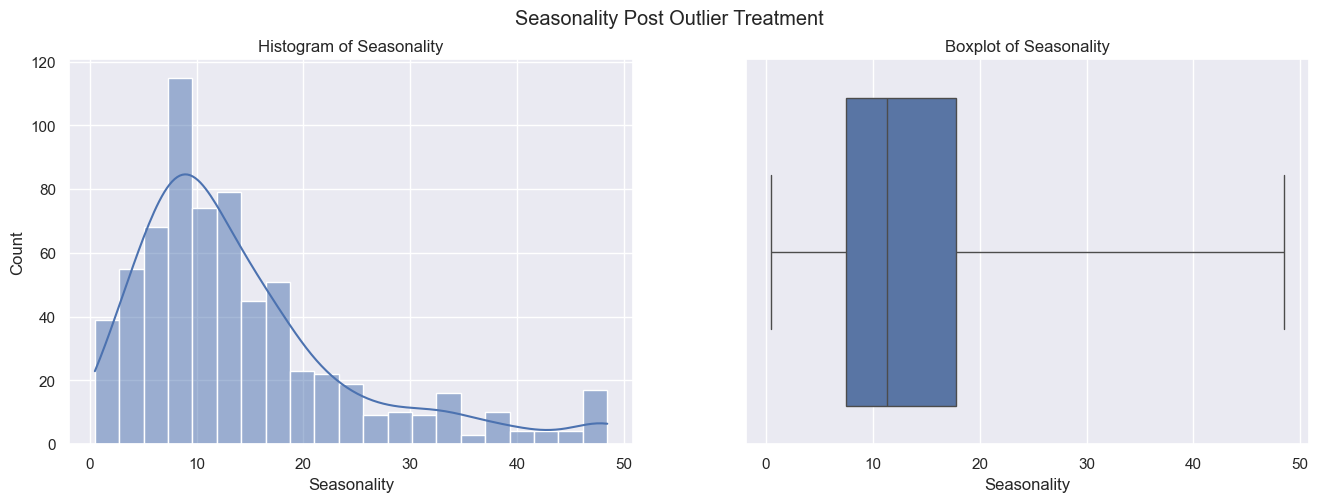

In [27]:
# Plotting histogram of Seasonality

fig, (ax1, ax2) =  plt.subplots(nrows=1, ncols=2, figsize=(16,5))

sns.histplot(df['s'], kde=True, ax=ax1)
ax1.set_xlabel('Seasonality')
ax1.set_title('Histogram of Seasonality')

sns.boxplot(x=df['s'], ax=ax2, whis=3.0)
ax2.set_xlabel('Seasonality')
ax2.set_title('Boxplot of Seasonality')

plt.suptitle('Seasonality Post Outlier Treatment')

plt.show()

* There seem to be a good amount of outliers in this column
* However, there may be a relationship between the value of seasonality and the month

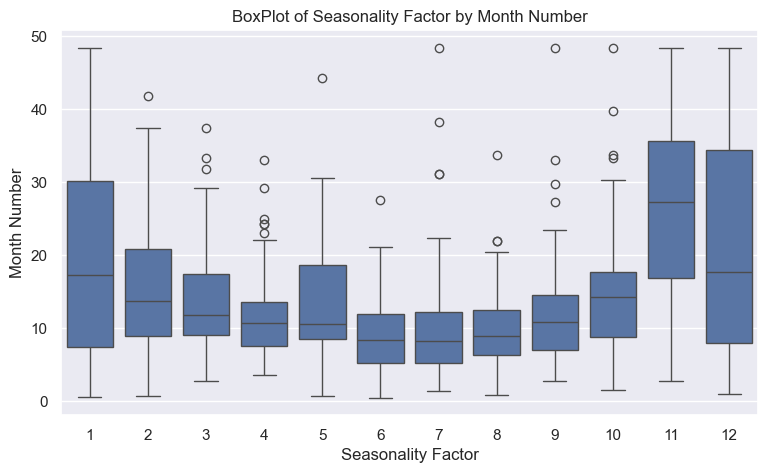

In [28]:
plt.figure(figsize=(9,5))
sns.boxplot(data=df, x='month', y='s')
plt.xlabel('Seasonality Factor')
plt.ylabel('Month Number')
plt.title('BoxPlot of Seasonality Factor by Month Number')
plt.show()

In [29]:
month_1 = df[df['month'] == 1]['s']
month_2 = df[df['month'] == 2]['s']
month_3 = df[df['month'] == 3]['s']
month_4 = df[df['month'] == 4]['s']
month_5 = df[df['month'] == 5]['s']
month_6 = df[df['month'] == 6]['s']
month_7 = df[df['month'] == 7]['s']
month_8 = df[df['month'] == 8]['s']
month_9 = df[df['month'] == 9]['s']
month_10 = df[df['month'] == 10]['s']
month_11 = df[df['month'] == 11]['s']
month_12 = df[df['month'] == 12]['s']

In [30]:
# Setting up a Kruskal Wallis test to check whether Seasonality and Month are indeed related
# We cannot use Anova as the individual groups seen in the above boxplot are not gaussian, but skewed

# H0: There is no significant difference in seasonality scores among the different months.
# Ha: There is a significant difference in seasonality scores among the different months.

alpha = 0.05
kruskal_stat, p_value = kruskal(month_1, month_2, month_3, month_4,month_5, month_6, 
                                month_7, month_8, month_9, month_10, month_11, month_12)

print(f"P value: {p_value}, Kruskal Statistic: {kruskal_stat}")
if p_value < alpha: 
    print("Reject the Null Hypothesis")
else:
    print("Failed to Reject the Null Hypothesis")

P value: 2.453405993070984e-18, Kruskal Statistic: 109.3646777160709
Reject the Null Hypothesis


### Observations
* Seasonality has a right skewed distribution with around 7.84% Outliers present in the column
* Larger values in seasonality could be due to year-end time where the prices may fluctuate
* Outliers have been thus treated with 3x IQR capping method
* As per the Kruskal Wallis Test, we can conclude that difference in Seasonality across different months is statistically significant (with 95% confidence)

### Competitor Prices
Analyzing the Competitor Prices captures by the columns - 'comp_1', 'comp_2' and 'comp_3' and our prices

In [31]:
df[['unit_price','comp_1','comp_2','comp_3']].describe().T

,count,mean,std,min,25%,50%,75%,max
unit_price,676.0,100.528311,59.500231,19.9,53.900000,89.90,129.990000,244.125
comp_1,676.0,79.452054,47.933358,19.9,49.910000,69.90,104.256549,349.900
comp_2,676.0,92.930079,49.481269,19.9,53.900000,89.99,117.888889,349.900
comp_3,676.0,84.182642,47.745789,19.9,53.785714,59.90,99.990000,255.610


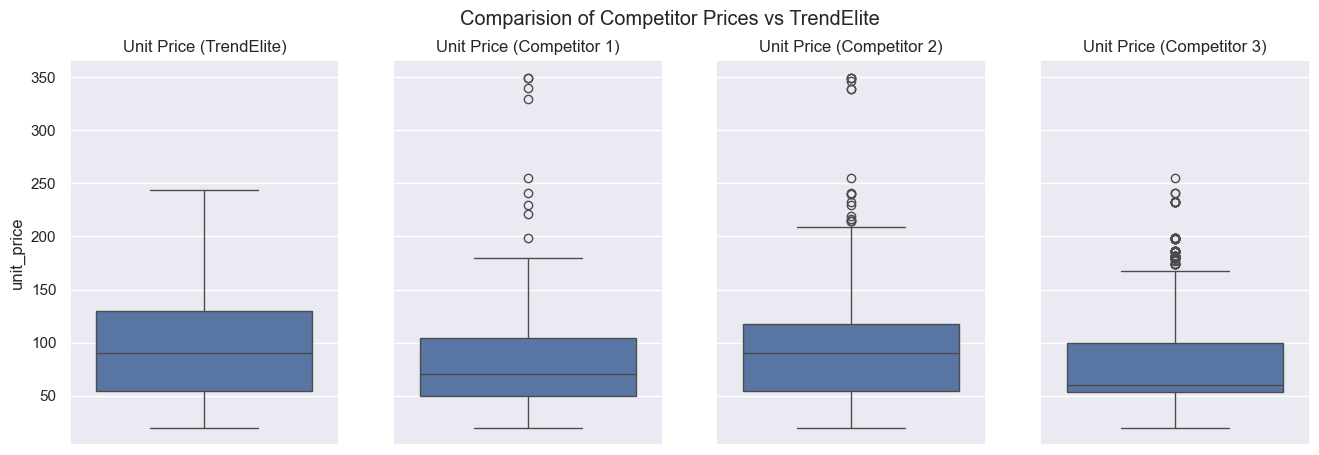

In [32]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=1, ncols=4, figsize=(16,5), sharey=True)

sns.boxplot(data=df, y='unit_price', ax=ax1)
ax1.set_title('Unit Price (TrendElite)')

sns.boxplot(data=df, y='comp_1', ax=ax2)
ax2.set_title('Unit Price (Competitor 1)')

sns.boxplot(data=df, y='comp_2', ax=ax3)
ax3.set_title('Unit Price (Competitor 2)')

sns.boxplot(data=df, y='comp_3', ax=ax4)
ax4.set_title('Unit Price (Competitor 3)')

plt.suptitle('Comparision of Competitor Prices vs TrendElite')
plt.show()

In [33]:
outlier_report(data=df, cols=['unit_price','comp_1','comp_2','comp_3'])

******************* Outlier Report *******************

Column: unit_price, Number of Outliers: 0, Percentage of Outliers: 0.0%

Column: comp_1, Number of Outliers: 9, Percentage of Outliers: 1.33%

Column: comp_2, Number of Outliers: 17, Percentage of Outliers: 2.51%

Column: comp_3, Number of Outliers: 58, Percentage of Outliers: 8.58%

******************************************************


In [34]:
cols_to_treat = ['unit_price','comp_1','comp_2','comp_3']

for col in cols_to_treat:
    df[col] = treat_outliers(data=df, col=col)

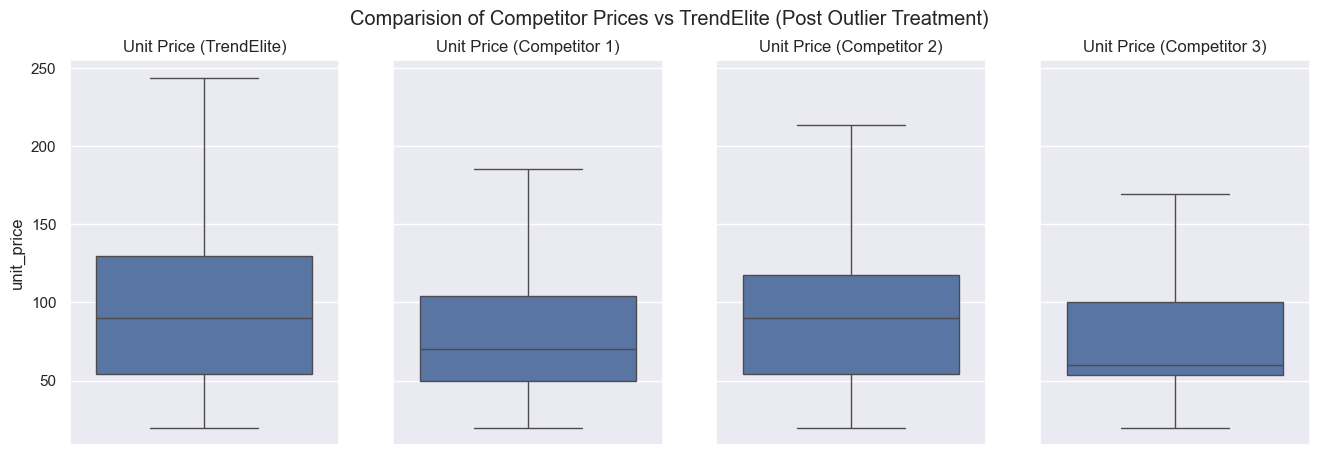

In [35]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=1, ncols=4, figsize=(16,5), sharey=True)

sns.boxplot(data=df, y='unit_price', ax=ax1)
ax1.set_title('Unit Price (TrendElite)')

sns.boxplot(data=df, y='comp_1', ax=ax2)
ax2.set_title('Unit Price (Competitor 1)')

sns.boxplot(data=df, y='comp_2', ax=ax3)
ax3.set_title('Unit Price (Competitor 2)')

sns.boxplot(data=df, y='comp_3', ax=ax4)
ax4.set_title('Unit Price (Competitor 3)')

plt.suptitle('Comparision of Competitor Prices vs TrendElite (Post Outlier Treatment)')
plt.show()

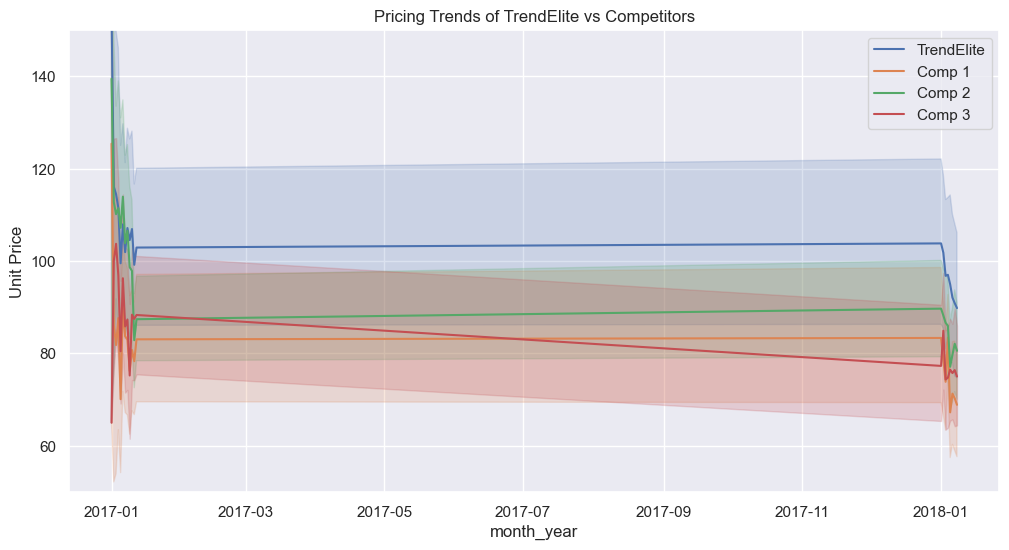

In [36]:
plt.figure(figsize=(12, 6))  
sns.lineplot(data=df, x='month_year', y='unit_price', label='TrendElite')
sns.lineplot(data=df, x='month_year', y='comp_1', label='Comp 1')
sns.lineplot(data=df, x='month_year', y='comp_2', label='Comp 2')
sns.lineplot(data=df, x='month_year', y='comp_3', label='Comp 3')
plt.ylabel('Unit Price')
plt.title('Pricing Trends of TrendElite vs Competitors')
plt.ylim(50,150)
plt.legend()
plt.show()

#### Observations:
* TrendElite has an aggressive pricing strategy based on the lineplot
* The average price across different months is usually higher than its competitors

### Competitor Freight Prices

In [37]:
df[['freight_price','fp1','fp2','fp3']].describe().T

,count,mean,std,min,25%,50%,75%,max
freight_price,676.0,19.706159,7.481135,2.834443,14.761912,17.518472,22.713558,34.641027
fp1,676.0,18.597610,9.406537,0.095439,13.826429,16.618984,19.732500,57.230000
fp2,676.0,18.620644,6.424174,4.410000,14.485000,16.811765,21.665238,57.230000
fp3,676.0,17.965007,5.533256,7.670000,15.042727,16.517110,19.447778,57.230000


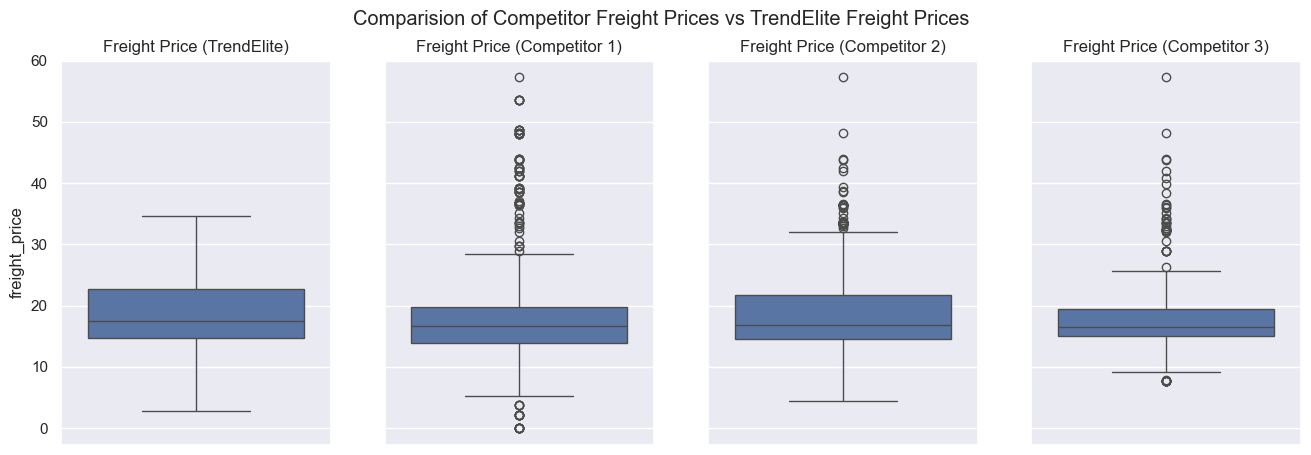

In [38]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=1, ncols=4, figsize=(16,5), sharey=True)

sns.boxplot(data=df, y='freight_price', ax=ax1)
ax1.set_title('Freight Price (TrendElite)')

sns.boxplot(data=df, y='fp1', ax=ax2)
ax2.set_title('Freight Price (Competitor 1)')

sns.boxplot(data=df, y='fp2', ax=ax3)
ax3.set_title('Freight Price (Competitor 2)')

sns.boxplot(data=df, y='fp3', ax=ax4)
ax4.set_title('Freight Price (Competitor 3)')

plt.suptitle('Comparision of Competitor Freight Prices vs TrendElite Freight Prices')
plt.show()

In [39]:
outlier_report(data=df, cols=['freight_price','fp1','fp2','fp3'])

******************* Outlier Report *******************

Column: freight_price, Number of Outliers: 0, Percentage of Outliers: 0.0%

Column: fp1, Number of Outliers: 96, Percentage of Outliers: 14.2%

Column: fp2, Number of Outliers: 44, Percentage of Outliers: 6.51%

Column: fp3, Number of Outliers: 50, Percentage of Outliers: 7.4%

******************************************************


In [40]:
cols_to_treat = ['fp1','fp2','fp3']

for col in cols_to_treat:
    df[col] = treat_outliers(data=df, col=col)

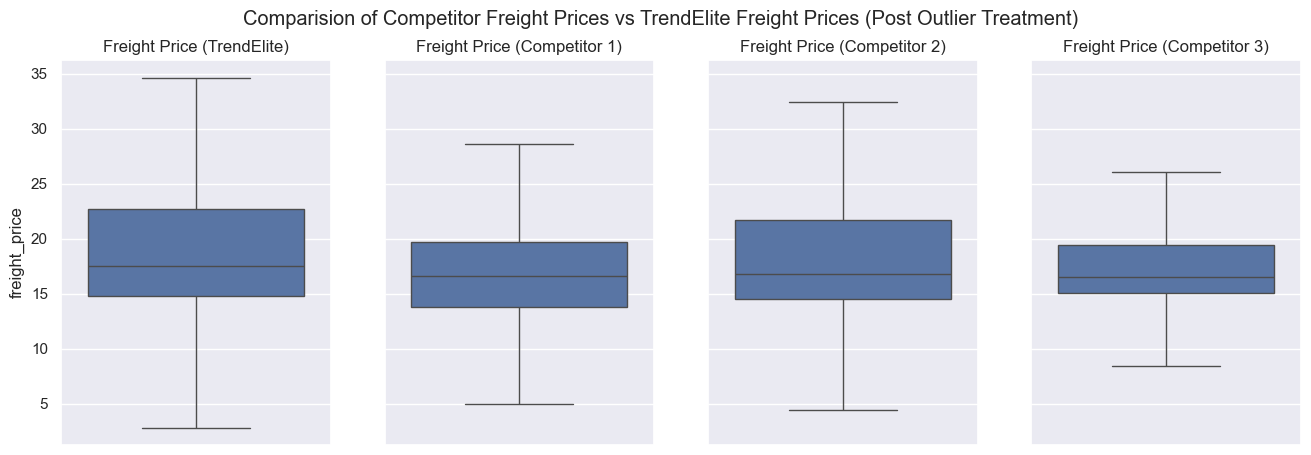

In [41]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=1, ncols=4, figsize=(16,5), sharey=True)

sns.boxplot(data=df, y='freight_price', ax=ax1)
ax1.set_title('Freight Price (TrendElite)')

sns.boxplot(data=df, y='fp1', ax=ax2)
ax2.set_title('Freight Price (Competitor 1)')

sns.boxplot(data=df, y='fp2', ax=ax3)
ax3.set_title('Freight Price (Competitor 2)')

sns.boxplot(data=df, y='fp3', ax=ax4)
ax4.set_title('Freight Price (Competitor 3)')

plt.suptitle('Comparision of Competitor Freight Prices vs TrendElite Freight Prices (Post Outlier Treatment)')
plt.show()

#### Observations:
* Based on the boxplots, we see similar freight pricing for our company and the three competitors
* Median prices for our company and competitors 1, 2 and 3 are 17.5, 16.6, 16.8 and 16.5 USD respectively (before treating outliers)

### Product Ratings

In [42]:
df[['product_score','ps1','ps2','ps3']].describe().T

,count,mean,std,min,25%,50%,75%,max
product_score,676.0,4.085503,0.232021,3.3,3.9,4.1,4.2,4.5
ps1,676.0,4.159467,0.121652,3.7,4.1,4.2,4.2,4.5
ps2,676.0,4.123521,0.207189,3.3,4.1,4.2,4.2,4.4
ps3,676.0,4.002071,0.233292,3.5,3.9,4.0,4.1,4.4


#### Observations:
* The product ratings on average are very similar across all 4 companies

### Creating Lagged version of Total Sales
As we may not have the total sales for a product for the current month in real time, we may want to look back at last month sales

In [43]:
df.sort_values('month_year', inplace=True)

In [44]:
df['total_price_lagged'] = df.groupby('product_id')['total_price'].shift(1)

In [45]:
df[df['product_id'] == 'bed1'][['product_id','product_category_name','month_year','total_price','total_price_lagged']]

,product_id,product_category_name,month_year,total_price,total_price_lagged
0,bed1,bed_bath_table,2017-01-05,45.95,NaN
1,bed1,bed_bath_table,2017-01-06,137.85,45.95
2,bed1,bed_bath_table,2017-01-07,275.70,137.85
3,bed1,bed_bath_table,2017-01-08,183.80,275.70
4,bed1,bed_bath_table,2017-01-09,91.90,183.80
5,bed1,bed_bath_table,2017-01-10,137.85,91.90
6,bed1,bed_bath_table,2017-01-11,445.85,137.85
7,bed1,bed_bath_table,2017-01-12,239.94,445.85
8,bed1,bed_bath_table,2018-01-01,759.81,239.94
9,bed1,bed_bath_table,2018-01-02,719.82,759.81


### Average Competitor Price

In [46]:
df['avg_comp_price'] = (df['comp_1'] + df['comp_2'] + df['comp_3']) / 3

In [47]:
df['avg_comp_price'].describe()

count    676.000000
mean      83.923959
std       36.887451
min       19.900000
25%       55.425000
50%       68.266667
75%      116.233333
max      189.648341
Name: avg_comp_price, dtype: float64

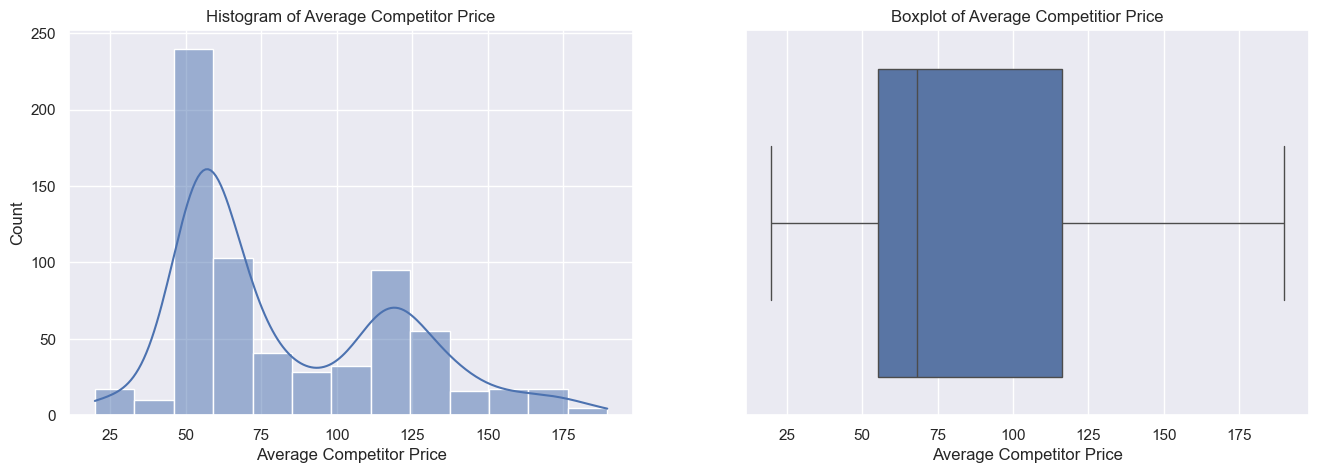

In [48]:
# Plotting histogram of Average Competitor Price

# Current Age
fig, (ax1, ax2) =  plt.subplots(nrows=1, ncols=2, figsize=(16,5))

sns.histplot(df['avg_comp_price'], kde=True, ax=ax1)
ax1.set_xlabel('Average Competitor Price')
ax1.set_title('Histogram of Average Competitor Price')

sns.boxplot(x=df['avg_comp_price'], ax=ax2)
ax2.set_xlabel('Average Competitor Price')
ax2.set_title('Boxplot of Average Competitior Price')

plt.show()

#### Observations
* From the above plots, we see that the average competitor price column has somewhat bi-modal distribution

In [49]:
df['avg_comp_freight_price'] = (df['fp1'] + df['fp2'] + df['fp3']) / 3

In [50]:
df['avg_comp_freight_price'].describe()

count    676.000000
mean      17.702161
std        4.048512
min        9.277500
25%       14.894600
50%       17.104054
75%       19.574329
max       29.027519
Name: avg_comp_freight_price, dtype: float64

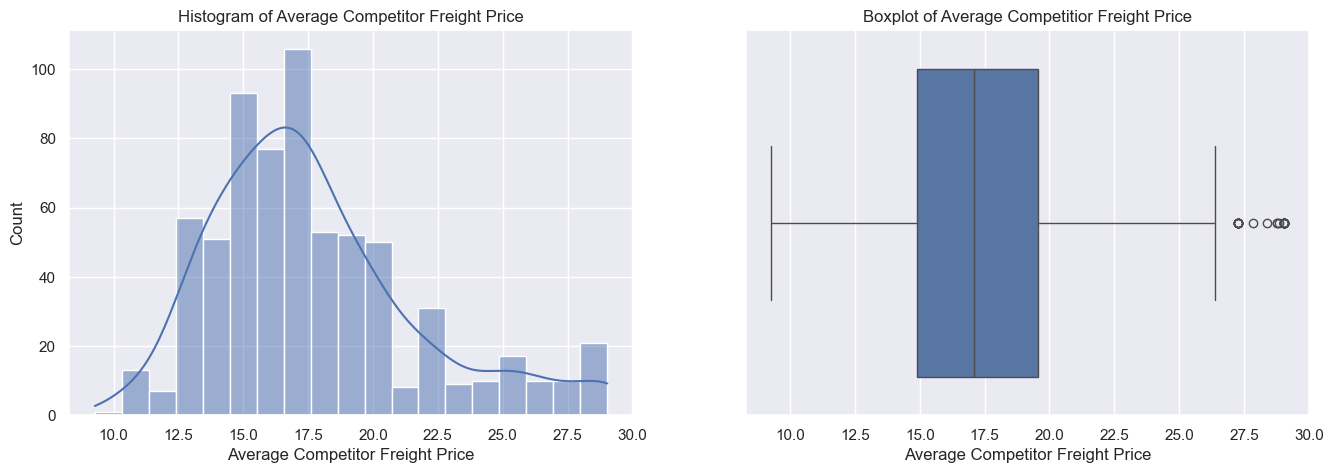

In [51]:
# Plotting histogram of Average Competitor Price

# Current Age
fig, (ax1, ax2) =  plt.subplots(nrows=1, ncols=2, figsize=(16,5))

sns.histplot(df['avg_comp_freight_price'], kde=True, ax=ax1)
ax1.set_xlabel('Average Competitor Freight Price')
ax1.set_title('Histogram of Average Competitor Freight Price')

sns.boxplot(x=df['avg_comp_freight_price'], ax=ax2)
ax2.set_xlabel('Average Competitor Freight Price')
ax2.set_title('Boxplot of Average Competitior Freight Price')

plt.show()

In [52]:
outlier_report(data=df, cols=['avg_comp_freight_price'])

******************* Outlier Report *******************

Column: avg_comp_freight_price, Number of Outliers: 31, Percentage of Outliers: 4.59%

******************************************************


In [53]:
# Treating the outliers
df['avg_comp_freight_price'] = treat_outliers(data=df, col='avg_comp_freight_price')

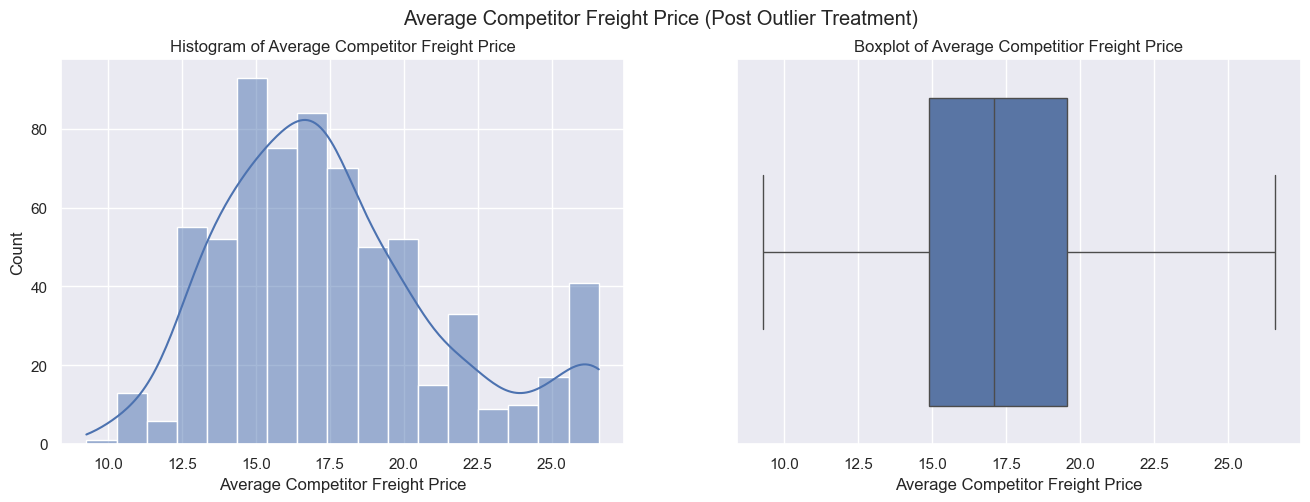

In [54]:
# Plotting histogram of Average Competitor Price

# Current Age
fig, (ax1, ax2) =  plt.subplots(nrows=1, ncols=2, figsize=(16,5))

sns.histplot(df['avg_comp_freight_price'], kde=True, ax=ax1)
ax1.set_xlabel('Average Competitor Freight Price')
ax1.set_title('Histogram of Average Competitor Freight Price')

sns.boxplot(x=df['avg_comp_freight_price'], ax=ax2)
ax2.set_xlabel('Average Competitor Freight Price')
ax2.set_title('Boxplot of Average Competitior Freight Price')

plt.suptitle('Average Competitor Freight Price (Post Outlier Treatment)')

plt.show()

### Average Competitor Freight Prices

## Bi-Variate / Multi-Variate Analysis

In [55]:
df.head()

,product_id,product_category_name,month_year,qty,total_price,freight_price,unit_price,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_score,customers,weekday,weekend,holiday,month,year,s,volume,comp_1,ps1,fp1,comp_2,ps2,fp2,comp_3,ps3,fp3,lag_price,total_price_lagged,avg_comp_price,avg_comp_freight_price
389,health7,health_beauty,2017-01-01,1.0,64.99,11.060000,64.990,59,492,2,200,3.9,9,22,9,1,1,2017,5.642857,3960,64.990000,3.9,11.060000,64.990000,3.9,11.060000,64.990000,3.9,11.060000,64.94,NaN,64.990000,11.060000
339,health5,health_beauty,2017-01-01,8.0,2799.20,22.901250,244.125,51,625,1,900,4.3,9,22,9,1,1,2017,12.771739,11400,185.776372,4.3,22.901250,213.872222,4.3,22.901250,64.990000,3.9,11.060000,349.85,NaN,154.879531,18.954167
438,bed2,bed_bath_table,2017-01-02,2.0,179.80,13.020000,89.900,54,245,1,1383,3.9,2,20,8,2,2,2017,8.872302,20000,89.900000,3.9,13.020000,89.900000,3.9,13.020000,89.900000,3.9,13.020000,89.85,NaN,89.900000,13.020000
236,garden8,garden_tools,2017-01-02,1.0,179.99,33.540000,179.990,33,2188,2,7650,4.2,3,20,8,2,2,2017,8.942308,8000,179.990000,4.2,28.591607,179.990000,4.2,32.435595,169.296429,4.2,26.055354,179.94,NaN,176.425476,26.593922
58,health9,health_beauty,2017-01-02,11.0,219.89,11.750909,19.990,48,575,1,100,4.3,19,20,8,2,2,2017,14.944444,4500,19.990000,4.3,11.750909,19.990000,4.3,11.750909,64.990000,3.9,15.348000,19.94,NaN,34.990000,12.949939


In [56]:
# Picking only a few relevant columns for analysis

num_vars = ['qty','total_price','total_price_lagged','freight_price','customers','holiday','s','volume','comp_1',
            'ps1','fp1','comp_2','ps2','fp2','comp_3','ps3','fp3','avg_comp_price','avg_comp_freight_price','lag_price','unit_price']

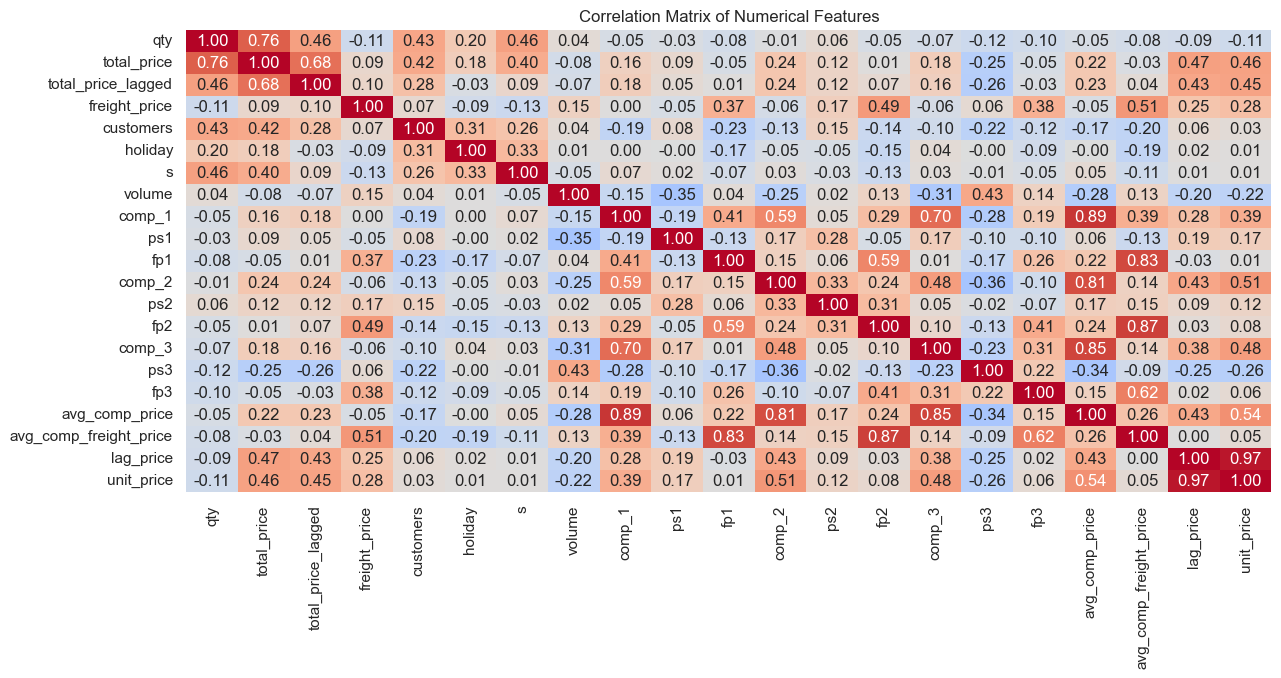

In [57]:
plt.figure(figsize=(14,6))
corr_matrix = df[num_vars].corr()
sns.heatmap(corr_matrix, cmap='coolwarm', vmax=1, vmin=-1, annot=True, fmt=".2f", cbar=False)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

#### Observations:
Some key takeaways from the above correlation matrix are:
1. Unit Price has a <b>very strong positive correlation (0.97)</b> with the lag price i.e., last months price. This goes to say that the product's last month price can be a good feature when it comes to predicting the current price
2. We see some weaker positive relationships of target price with other features such as <b>'comp_2' (0.51), 'comp_3' (0.48)</b> and <b>comp_1 (0.39) </b>. While these correlations are weak, the relationships are worth studying in order to understand the relationship between the unit price and competitor prices, and also current month sales
3. Unit Price also seems to have a decent correlation with the lagged total price of <b>0.45</b> (which is simply last month sales)
4. The Average Competitor Price column has a correlation of <b>0.54</b> that is higher than that of any other individual competitor price columns. We also see how the average competitor price is heavily correlated with these individual columns. We can get rid of the individual price columns for the competitors

### Relationship of Unit Price with Lag Price and Total Sales (Lagged)

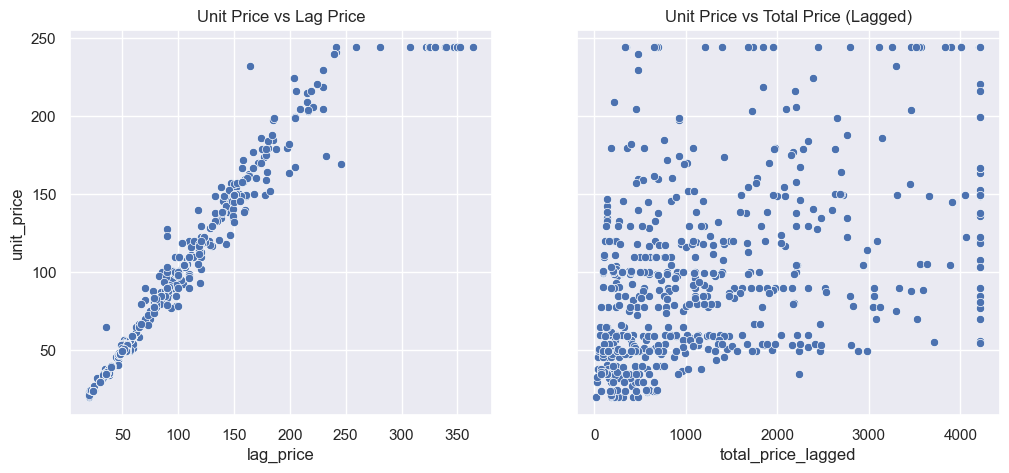

In [58]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12,5))

sns.scatterplot(data=df, x='lag_price', y='unit_price', ax=ax1)
ax1.set_title('Unit Price vs Lag Price')

sns.scatterplot(data=df, x='total_price_lagged', y='unit_price', ax=ax2)
ax2.set_title('Unit Price vs Total Price (Lagged)')

plt.show()

### Observations:
* Lag Price can be a strong predictor of the Unit Price based on the Scatter Plot
* We see a more noisy relationship between Unit Price and Total Price

### Impact of Competitor Pricing on Unit Price

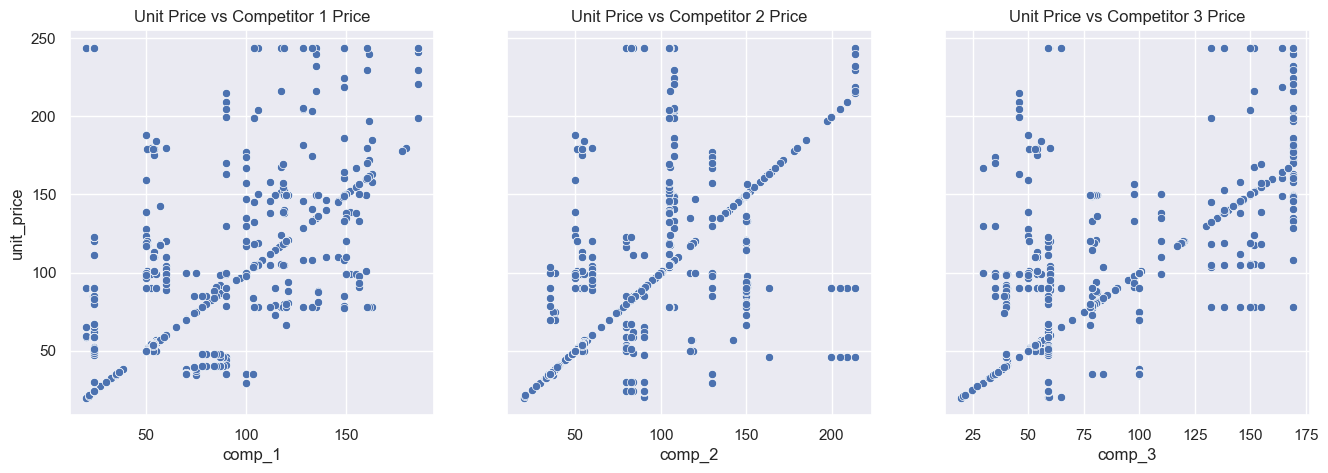

In [59]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(16,5))

sns.scatterplot(data=df, x='comp_1', y='unit_price', ax=ax1)
ax1.set_title('Unit Price vs Competitor 1 Price')

sns.scatterplot(data=df, x='comp_2', y='unit_price', ax=ax2)
ax2.set_title('Unit Price vs Competitor 2 Price')

sns.scatterplot(data=df, x='comp_3', y='unit_price', ax=ax3)
ax3.set_title('Unit Price vs Competitor 3 Price')

plt.show()

### Observations:
The relationship between Unit Price and Competitor Price is weak, but there are some linear patterns observed

In [60]:
df.head()

,product_id,product_category_name,month_year,qty,total_price,freight_price,unit_price,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_score,customers,weekday,weekend,holiday,month,year,s,volume,comp_1,ps1,fp1,comp_2,ps2,fp2,comp_3,ps3,fp3,lag_price,total_price_lagged,avg_comp_price,avg_comp_freight_price
389,health7,health_beauty,2017-01-01,1.0,64.99,11.060000,64.990,59,492,2,200,3.9,9,22,9,1,1,2017,5.642857,3960,64.990000,3.9,11.060000,64.990000,3.9,11.060000,64.990000,3.9,11.060000,64.94,NaN,64.990000,11.060000
339,health5,health_beauty,2017-01-01,8.0,2799.20,22.901250,244.125,51,625,1,900,4.3,9,22,9,1,1,2017,12.771739,11400,185.776372,4.3,22.901250,213.872222,4.3,22.901250,64.990000,3.9,11.060000,349.85,NaN,154.879531,18.954167
438,bed2,bed_bath_table,2017-01-02,2.0,179.80,13.020000,89.900,54,245,1,1383,3.9,2,20,8,2,2,2017,8.872302,20000,89.900000,3.9,13.020000,89.900000,3.9,13.020000,89.900000,3.9,13.020000,89.85,NaN,89.900000,13.020000
236,garden8,garden_tools,2017-01-02,1.0,179.99,33.540000,179.990,33,2188,2,7650,4.2,3,20,8,2,2,2017,8.942308,8000,179.990000,4.2,28.591607,179.990000,4.2,32.435595,169.296429,4.2,26.055354,179.94,NaN,176.425476,26.593922
58,health9,health_beauty,2017-01-02,11.0,219.89,11.750909,19.990,48,575,1,100,4.3,19,20,8,2,2,2017,14.944444,4500,19.990000,4.3,11.750909,19.990000,4.3,11.750909,64.990000,3.9,15.348000,19.94,NaN,34.990000,12.949939


### Average Unit Price for different Product Categories

In [61]:
prod_avg_order = df.groupby('product_category_name')['unit_price'].median().reset_index().sort_values('unit_price', ascending=False)['product_category_name']

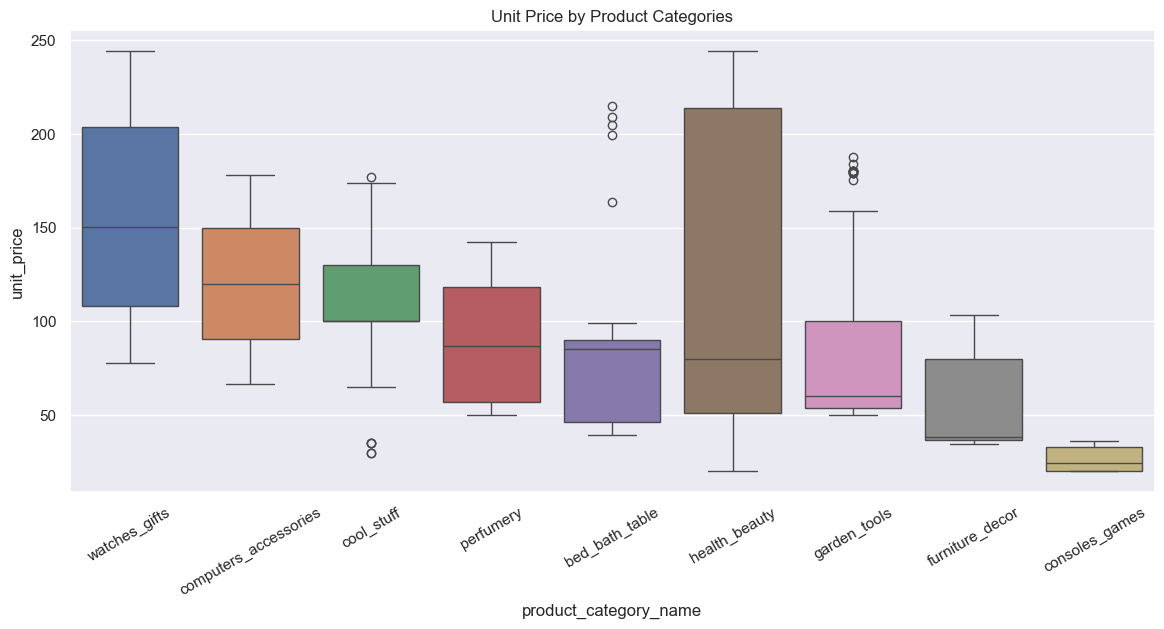

In [62]:
plt.figure(figsize=(14,6))
sns.boxplot(data=df, x='product_category_name', y='unit_price', order=prod_avg_order, palette='deep')
plt.xticks(rotation=30)
plt.title('Unit Price by Product Categories')

plt.show()

In [63]:
df.groupby('product_category_name')['total_price'].sum()

product_category_name
bed_bath_table            77505.59750
computers_accessories    118094.55250
consoles_games             5800.70000
cool_stuff                57300.37250
furniture_decor           48482.18500
garden_tools             162356.21875
health_beauty            189459.68875
perfumery                 20312.52000
watches_gifts            186555.76250
Name: total_price, dtype: float64

In [64]:
prod_catg_revenue = df.groupby('product_category_name')['total_price'].sum().reset_index().sort_values('total_price', ascending=False)['product_category_name']

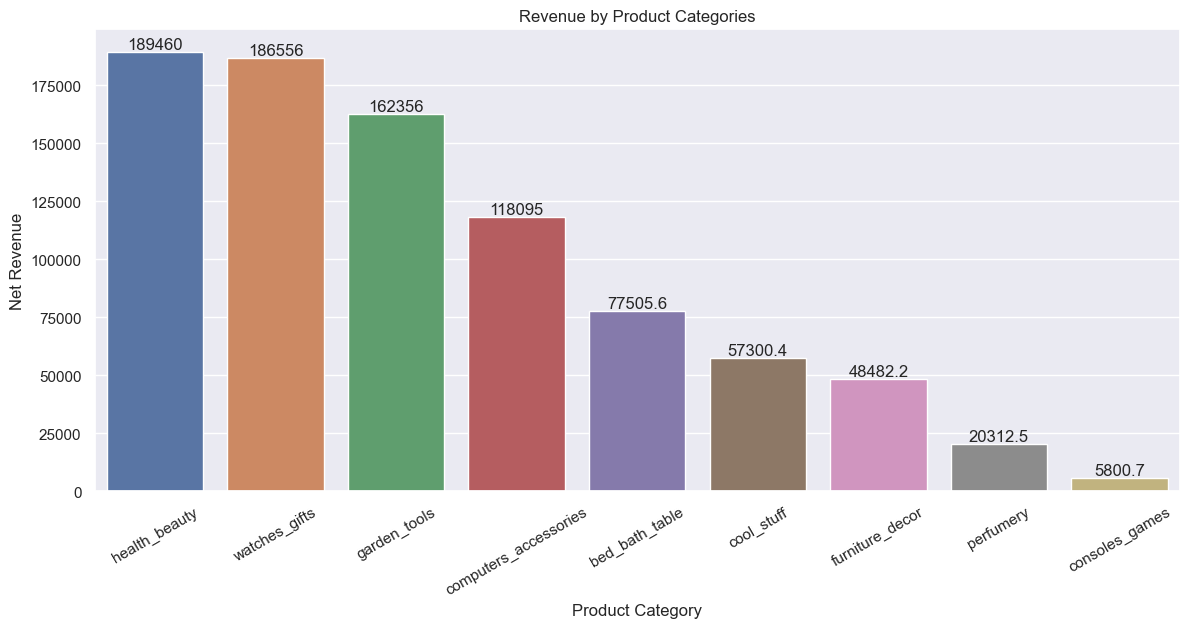

In [65]:
# Contribution of product categories to net revenue

plt.figure(figsize=(14,6))
ax = sns.barplot(data=df, x='product_category_name', y='total_price', order=prod_catg_revenue, estimator='sum', ci=False, palette='deep')

# Add bar labels to all bars
for container in ax.containers:
    ax.bar_label(container)

plt.ylabel('Net Revenue')
plt.xlabel('Product Category')
plt.xticks(rotation=30)
plt.title('Revenue by Product Categories')

plt.show()


In [122]:
product_catg_revenue = df.groupby('product_category_name').agg({'product_id':'nunique', 'total_price': 'sum'}).reset_index()
product_catg_revenue.columns = ['product_category_name','num_products','total_revenue']

In [123]:
product_catg_revenue

,product_category_name,num_products,total_revenue
0,bed_bath_table,5,77505.59750
1,computers_accessories,6,118094.55250
2,consoles_games,2,5800.70000
3,cool_stuff,5,57300.37250
4,furniture_decor,4,48482.18500
5,garden_tools,10,162356.21875
6,health_beauty,10,189459.68875
7,perfumery,2,20312.52000
8,watches_gifts,8,186555.76250


<Figure size 900x500 with 0 Axes>

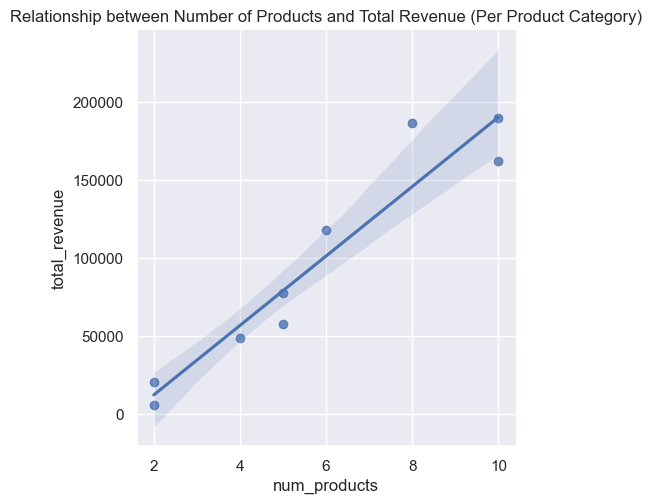

In [132]:
sns.lmplot(data=product_catg_revenue, x='num_products', y='total_revenue')
plt.title('Relationship between Number of Products and Total Revenue (Per Product Category)')
plt.show()

#### Observations:
1. Product Categories such as Watches_Gifts, Computer Accessories and Cool stuff have the highest median unit prices
2. On the other hand, garden tools, furniture and decor, console games have the lowest unit prices
3. However, health and beauty, watches and gifts. garden tools have the highest contribution to revenue
4. We see a relationship between total revenue generated and the number of products in a product category

## Creating columns related to profitability
We can break profitability as:
* Profit = Revenue - Costs <br>
  Here, Revenue corresponds to the total_price column, and the only cost available to us is the freight price. <br>
  Monthly freight expenses per product can be calculated as qty * freight_price <br>
* Hence, Profit per product = Total Price - (qty * freight_price)

In [66]:
# Adding a new column as costs 
df['total_costs'] = df['qty'] * df['freight_price']
df['profit'] = df['total_price'] - df['total_costs']

In [67]:
df['profit'].describe()

count     676.000000
mean     1029.895206
std      1064.758365
min         8.050000
25%       212.280000
50%       621.025000
75%      1549.505939
max      4107.212978
Name: profit, dtype: float64

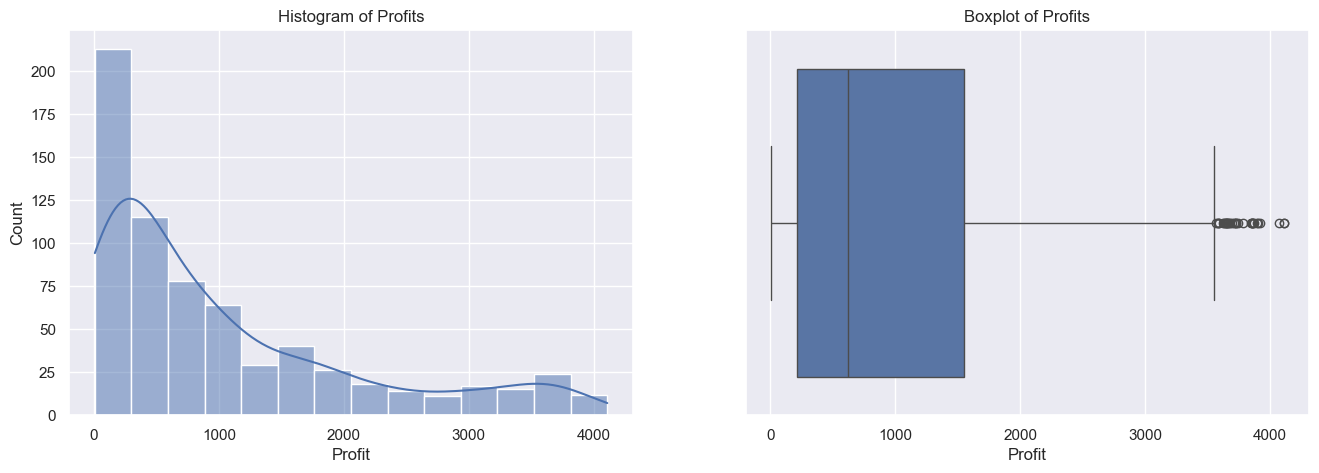

In [68]:
# Plotting histogram of Profits

# Current Age
fig, (ax1, ax2) =  plt.subplots(nrows=1, ncols=2, figsize=(16,5))

sns.histplot(df['profit'], kde=True, ax=ax1)
ax1.set_xlabel('Profit')
ax1.set_title('Histogram of Profits')

sns.boxplot(x=df['profit'], ax=ax2)
ax2.set_xlabel('Profit')
ax2.set_title('Boxplot of Profits')

plt.show()

In [69]:
outlier_report(data=df, cols=['profit'])

******************* Outlier Report *******************

Column: profit, Number of Outliers: 33, Percentage of Outliers: 4.88%

******************************************************


In [70]:
# Treating outliers
df['profit'] = treat_outliers(data=df, col='profit')

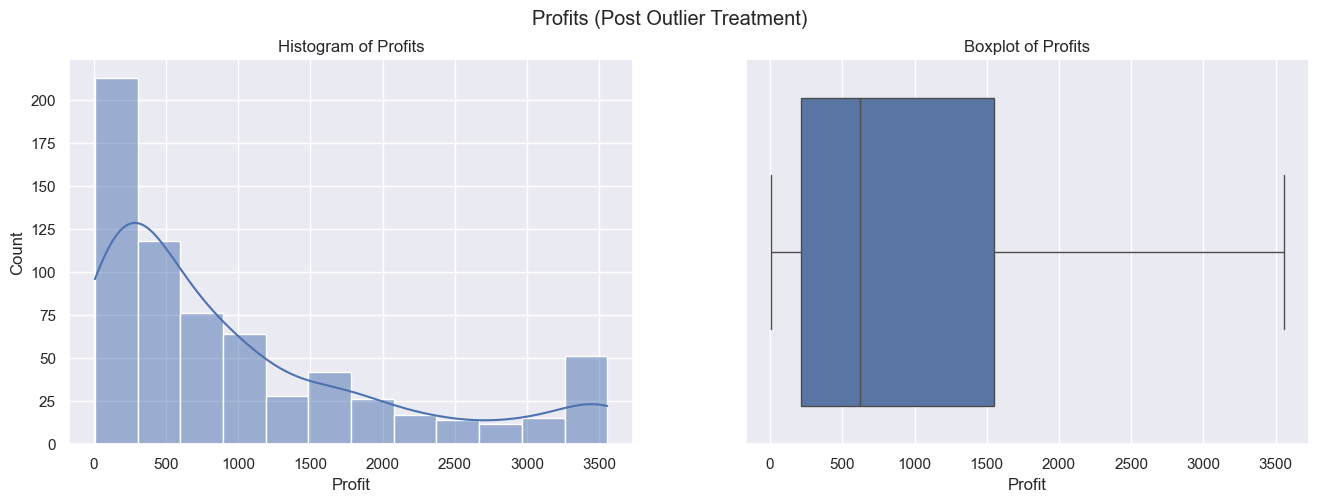

In [71]:
# Plotting histogram of Profits

# Current Age
fig, (ax1, ax2) =  plt.subplots(nrows=1, ncols=2, figsize=(16,5))

sns.histplot(df['profit'], kde=True, ax=ax1)
ax1.set_xlabel('Profit')
ax1.set_title('Histogram of Profits')

sns.boxplot(x=df['profit'], ax=ax2)
ax2.set_xlabel('Profit')
ax2.set_title('Boxplot of Profits')

plt.suptitle('Profits (Post Outlier Treatment)')

plt.show()

In [72]:
# Introducing a lag in profits to get last month profits

df.sort_values('month_year', inplace=True)
df['lagged_profit'] = df.groupby('product_id')['profit'].shift(1)

### Do Product Name and Description Length tell us something about its Unit Price?

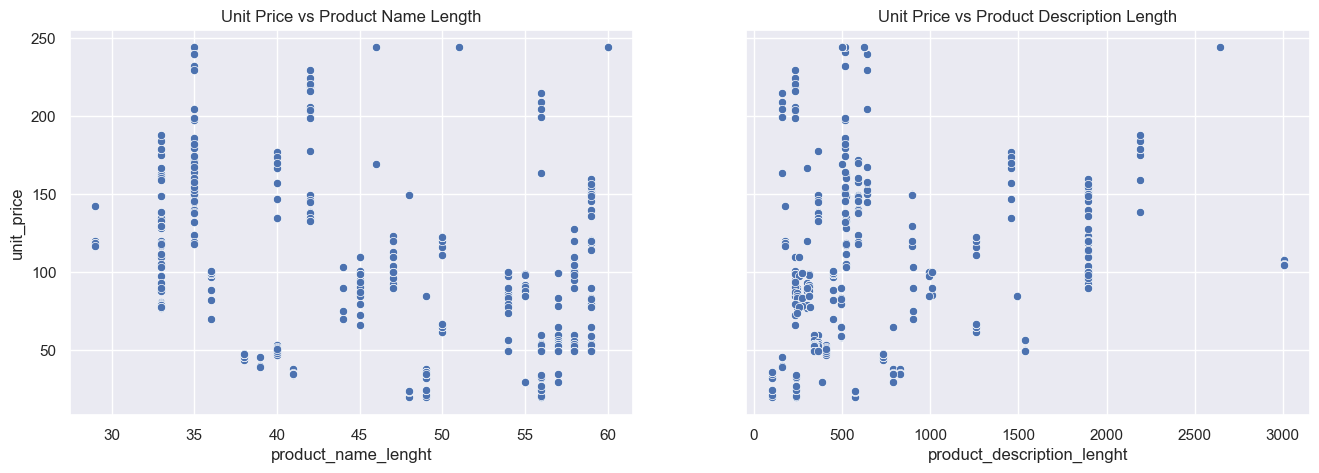

In [73]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16,5))

sns.scatterplot(data=df, x='product_name_lenght', y='unit_price', ax=ax1)
ax1.set_title('Unit Price vs Product Name Length')

sns.scatterplot(data=df, x='product_description_lenght', y='unit_price', ax=ax2)
ax2.set_title('Unit Price vs Product Description Length')

plt.show()

In [74]:
df[['product_name_lenght','product_description_lenght','unit_price']].corr()

,product_name_lenght,product_description_lenght,unit_price
product_name_lenght,1.000000,0.124510,-0.257146
product_description_lenght,0.124510,1.000000,0.301794
unit_price,-0.257146,0.301794,1.000000


* We see some weak relationships between unit price and product name and description lengths

### Exploring Demand Elasticity
Demand elasticity depends on two factor - 
1. Changes in Quantity
2. Changes in Price

Changes in Quantity can be calculated as <b>del_q = (Q2 - Q1) / Q1</b> where Q1 is last month quantity and Q2 is current month quantity <br>
Similarly, changes in Prices can be calculated as <b>del_p = (P2 - P1) / P1 </b>where P1 is last month price and P2 is current month price <br><br>

Finally, Demand Elasticity can be calculated as <b>del_q / del_p</b>

In [75]:
df.head()

,product_id,product_category_name,month_year,qty,total_price,freight_price,unit_price,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_score,customers,weekday,weekend,holiday,month,year,s,volume,comp_1,ps1,fp1,comp_2,ps2,fp2,comp_3,ps3,fp3,lag_price,total_price_lagged,avg_comp_price,avg_comp_freight_price,total_costs,profit,lagged_profit
389,health7,health_beauty,2017-01-01,1.0,64.99,11.06000,64.990,59,492,2,200,3.9,9,22,9,1,1,2017,5.642857,3960,64.990000,3.9,11.060000,64.990000,3.9,11.060000,64.99,3.9,11.060000,64.94,NaN,64.990000,11.060000,11.06,53.93,NaN
339,health5,health_beauty,2017-01-01,8.0,2799.20,22.90125,244.125,51,625,1,900,4.3,9,22,9,1,1,2017,12.771739,11400,185.776372,4.3,22.901250,213.872222,4.3,22.901250,64.99,3.9,11.060000,349.85,NaN,154.879531,18.954167,183.21,2615.99,NaN
420,garden3,garden_tools,2017-01-02,1.0,99.99,33.00000,99.990,47,1893,1,6050,4.1,3,20,8,2,2,2017,11.586851,8000,99.990000,4.1,28.591607,99.990000,4.1,32.435595,99.99,4.1,26.055354,99.94,NaN,99.990000,26.593922,33.00,66.99,NaN
583,computers4,computers_accessories,2017-01-02,3.0,479.97,33.40000,159.990,59,1893,1,6550,4.2,3,20,8,2,2,2017,7.889031,8000,159.990000,4.2,28.591607,159.990000,4.2,32.435595,159.99,4.2,26.055354,159.94,NaN,159.990000,26.593922,100.20,379.77,NaN
550,garden1,garden_tools,2017-01-02,1.0,99.99,28.89000,99.990,58,1893,1,5950,4.3,3,20,8,2,2,2017,7.510204,8000,99.990000,4.3,28.591607,99.990000,4.3,28.890000,99.99,4.3,26.055354,99.94,NaN,99.990000,26.593922,28.89,71.10,NaN


In [76]:
# Calculating Price Changes

df['price_change'] = (df['unit_price'] - df['lag_price'] )/ df['lag_price']

In [77]:
# Calculating previous month quantity

df.sort_values(by='month_year', inplace=True)
df['prev_qty'] = df.groupby('product_id')['qty'].shift(1)

In [78]:
df['qty_change'] =  (df['qty'] - df['prev_qty'] )/ df['prev_qty']

In [79]:
df['demand_elasticity'] = df['qty_change'] / df['price_change']

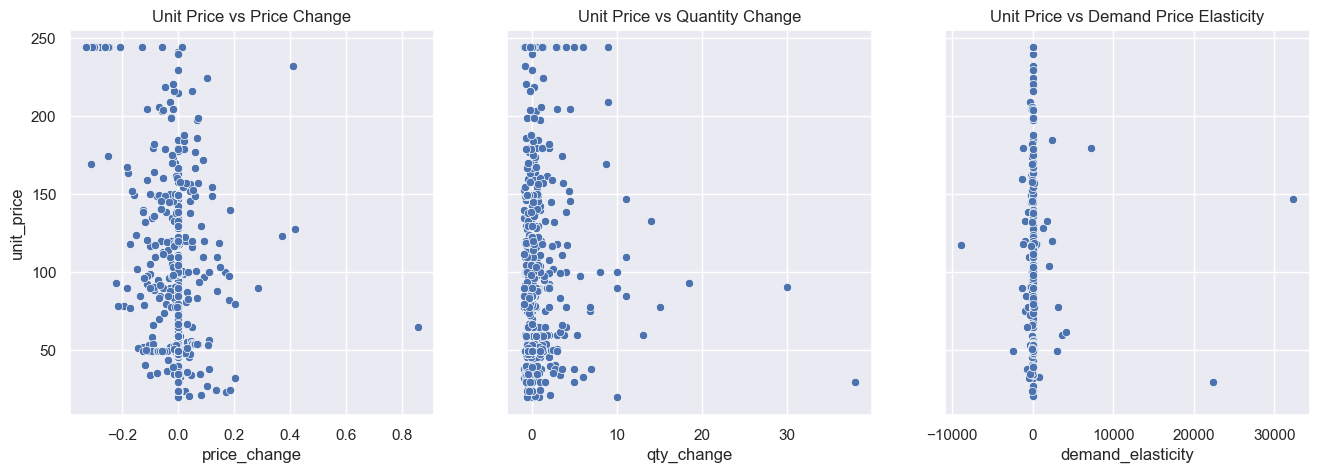

In [80]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(16,5))

sns.scatterplot(data=df, x='price_change', y='unit_price', ax=ax1)
ax1.set_title('Unit Price vs Price Change')

sns.scatterplot(data=df, x='qty_change', y='unit_price', ax=ax2)
ax2.set_title('Unit Price vs Quantity Change')

sns.scatterplot(data=df, x='demand_elasticity', y='unit_price', ax=ax3)
ax3.set_title('Unit Price vs Demand Price Elasticity')

plt.show()

#### Observations:
* Based on the above plot, we see little to no pattern between the price change, quantity change and the demand price elasticity columns
* These may end up adding no value to our analysis

## Building a Dynamic Pricing Model

In [81]:
# Picking only relevant and potentially useful columns based on our analysis
cols = ['product_id','product_category_name','month','total_price_lagged','freight_price','product_name_lenght','product_description_lenght','s','avg_comp_price','lagged_profit','lag_price','unit_price']

In [82]:
df_modelling = df[cols].copy()

In [83]:
df_modelling.head()

,product_id,product_category_name,month,total_price_lagged,freight_price,product_name_lenght,product_description_lenght,s,avg_comp_price,lagged_profit,lag_price,unit_price
389,health7,health_beauty,1,NaN,11.060000,59,492,5.642857,64.990000,NaN,64.94,64.990
339,health5,health_beauty,1,NaN,22.901250,51,625,12.771739,154.879531,NaN,349.85,244.125
390,health7,health_beauty,2,64.99,15.348000,59,492,13.928571,49.990000,53.93,64.99,64.990
438,bed2,bed_bath_table,2,NaN,13.020000,54,245,8.872302,89.900000,NaN,89.85,89.900
58,health9,health_beauty,2,NaN,11.750909,48,575,14.944444,34.990000,NaN,19.94,19.990


In [84]:
df_modelling.isna().sum()

product_id                     0
product_category_name          0
month                          0
total_price_lagged            52
freight_price                  0
product_name_lenght            0
product_description_lenght     0
s                              0
avg_comp_price                 0
lagged_profit                 52
lag_price                      0
unit_price                     0
dtype: int64

In [85]:
# Imputing 
df_modelling['lagged_profit'] = df_modelling['lagged_profit'].fillna(df_modelling.groupby('product_id')['lagged_profit'].transform('median'))
df_modelling['total_price_lagged'] = df_modelling['total_price_lagged'].fillna(df_modelling.groupby('product_id')['total_price_lagged'].transform('median'))

### Splitting the data
Using a 70-30 Train-Test Split

In [86]:
X = df_modelling.drop('unit_price', axis=1)
y = df_modelling['unit_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [87]:
print(f"Training dataset Shape: {X_train.shape}, Testing dataset Shape: {X_test.shape}")

Training dataset Shape: (473, 11), Testing dataset Shape: (203, 11)


In [88]:
X_train.head()

,product_id,product_category_name,month,total_price_lagged,freight_price,product_name_lenght,product_description_lenght,s,avg_comp_price,lagged_profit,lag_price
52,garden7,garden_tools,3,411.20,21.350000,57,339,5.263158,53.900000,298.530000,51.40
86,health3,health_beauty,2,110.99,20.550000,50,1257,1.282051,57.656667,76.348973,110.99
75,health9,health_beauty,8,71.97,16.770000,48,575,8.007937,55.267143,15.540000,23.99
62,health9,health_beauty,6,319.84,12.683333,48,575,7.345238,56.259841,82.280000,19.99
421,garden3,garden_tools,3,99.99,30.539091,47,1893,11.830357,99.990000,66.990000,99.99


In [89]:
temp_df = pd.concat([X_train, y_train], axis=1)

In [90]:
product_id_target_encoding_dict = dict(temp_df.groupby('product_id')['unit_price'].mean())
product_catg_target_encoding_dict = dict(temp_df.groupby('product_category_name')['unit_price'].mean())
month_target_encoding_dict = dict(temp_df.groupby('month')['unit_price'].mean())

In [91]:
# Using the encoded dicts to encode the categorical cols
X_train['product_id'] = X_train['product_id'].map(product_id_target_encoding_dict)
X_train['product_category_name'] = X_train['product_category_name'].map(product_catg_target_encoding_dict)
X_train['month'] = X_train['month'].map(month_target_encoding_dict)

In [92]:
X_train.head()

,product_id,product_category_name,month,total_price_lagged,freight_price,product_name_lenght,product_description_lenght,s,avg_comp_price,lagged_profit,lag_price
52,55.066667,81.545642,103.276643,411.20,21.350000,57,339,5.263158,53.900000,298.530000,51.40
86,117.307308,108.221122,107.555425,110.99,20.550000,50,1257,1.282051,57.656667,76.348973,110.99
75,22.405954,108.221122,103.164378,71.97,16.770000,48,575,8.007937,55.267143,15.540000,23.99
62,22.405954,108.221122,95.052046,319.84,12.683333,48,575,7.345238,56.259841,82.280000,19.99
421,103.561378,81.545642,103.276643,99.99,30.539091,47,1893,11.830357,99.990000,66.990000,99.99


In [93]:
X_train_cols = X_train.columns

In [94]:
# Scaling the features
scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train_cols)

In [95]:
X_train.head()

,product_id,product_category_name,month,total_price_lagged,freight_price,product_name_lenght,product_description_lenght,s,avg_comp_price,lagged_profit,lag_price
0,-0.781241,-0.620132,0.349924,-0.757522,0.219477,0.912276,-0.670101,-0.859798,-0.840534,-0.738072,-0.727641
1,0.274052,0.223940,1.051943,-1.008512,0.112296,0.175917,0.729480,-1.248123,-0.737571,-0.955116,0.029786
2,-1.335006,0.223940,0.331505,-1.041135,-0.394130,-0.034472,-0.310296,-0.592067,-0.803063,-1.014519,-1.076039
3,-1.335006,0.223940,-0.999483,-0.833904,-0.941642,-0.034472,-0.310296,-0.656707,-0.775855,-0.949322,-1.126882
4,0.040989,-0.620132,0.349924,-1.017709,1.450587,-0.139666,1.699124,-0.219220,0.422695,-0.964259,-0.110031


In [96]:
# Pre-Processing the Test dataset
X_test['product_id'] = X_test['product_id'].map(product_id_target_encoding_dict)
X_test['product_category_name'] = X_test['product_category_name'].map(product_catg_target_encoding_dict)
X_test['month'] = X_test['month'].map(month_target_encoding_dict)

X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_train_cols)

In [97]:
lr_model = LinearRegression()

In [98]:
# Fitting Linear Regression Model to our dataset

lr_model.fit(X_train, y_train)

LinearRegression()

In [99]:
# Evaluating the base line model

evaluate_model(X_train, X_test, y_train, y_test, lr_model)

Train R2 Score: 0.9770249085737455, Train Adjusted R2 Score: 0.9764766959800605
Test R2 Score: 0.9722979066936341, Test Adjusted R2 Score: 0.9707024981786079


In [100]:
baseline_model_vif = vif_report(X_train)
baseline_model_vif

,Features,VIF
9,lagged_profit,111.82
3,total_price_lagged,102.48
0,product_id,24.57
10,lag_price,19.57
8,avg_comp_price,2.52
1,product_category_name,2.36
4,freight_price,1.81
5,product_name_lenght,1.44
6,product_description_lenght,1.40
7,s,1.06


#### Observations:
* The baseline model is resulting in good train and test R2 as well as Adjusted R2 scores meaning that all of the feautures are useful
* However, the VIF report shows very high degree of Multi-Colinearity which is something that needs to be dealt with in order to achieve model interpretability

### Refining the Model
Removing features that have high degree of multi-colinearity (vif score > 10)

In [101]:
# In the v1 version of the model, we remove the profit lagged column that has a VIF score of 111

X_train_v1 = X_train.drop('lagged_profit', axis=1)
X_test_v1 = X_test.drop('lagged_profit', axis=1)

In [102]:
# Initialize and train the model on v1 dataset

lr_model_v1 = LinearRegression()
lr_model_v1.fit(X_train_v1, y_train)

LinearRegression()

In [103]:
# Print Model Evaluation Report

evaluate_model(X_train_v1, X_test_v1, y_train, y_test, lr_model_v1)

Train R2 Score: 0.9769722547861632, Train Adjusted R2 Score: 0.9764738187425737
Test R2 Score: 0.9725577398314574, Test Adjusted R2 Score: 0.9711284554476792


In [104]:
# Print the VIF report

v1_model_vif = vif_report(X_train_v1)
v1_model_vif

,Features,VIF
0,product_id,24.55
9,lag_price,18.83
8,avg_comp_price,2.52
1,product_category_name,2.35
4,freight_price,1.54
3,total_price_lagged,1.42
5,product_name_lenght,1.42
6,product_description_lenght,1.40
7,s,1.06
2,month,1.04


#### Observations:
* Upon removing the Profit Lagged Column, the model performance has barely changed, however the multi-colinearity in the model has reduced
* However, there still are columns such as product_id and lag_price that have high vif scores which need to be addressed

In [105]:
# Training a v2 model

X_train_v2 = X_train_v1.drop('product_id', axis=1)
X_test_v2 = X_test_v1.drop('product_id', axis=1)

In [106]:
# Initialize and train the model on v2 dataset

lr_model_v2 = LinearRegression()
lr_model_v2.fit(X_train_v2, y_train)

LinearRegression()

In [107]:
# Print Model Evaluation Report

evaluate_model(X_train_v2, X_test_v2, y_train, y_test, lr_model_v2)

Train R2 Score: 0.9652088271220113, Train Adjusted R2 Score: 0.964532540824167
Test R2 Score: 0.9639534525921348, Test Adjusted R2 Score: 0.962272525510939


In [108]:
# Print the VIF report

v2_model_vif = vif_report(X_train_v2)
v2_model_vif

,Features,VIF
7,avg_comp_price,2.39
0,product_category_name,2.25
8,lag_price,1.72
3,freight_price,1.38
5,product_description_lenght,1.37
2,total_price_lagged,1.32
4,product_name_lenght,1.27
6,s,1.06
1,month,1.03


In [109]:
lr_model_v2.feature_names_in_

array(['product_category_name', 'month', 'total_price_lagged',
       'freight_price', 'product_name_lenght',
       'product_description_lenght', 's', 'avg_comp_price', 'lag_price'],
      dtype=object)

In [110]:
# Model weights

model_coef = pd.DataFrame(data={'Features': lr_model_v2.feature_names_in_, 'Coefficients': lr_model_v2.coef_})

model_coef['abs_val'] = np.abs(model_coef['Coefficients'])

model_coef.sort_values('abs_val', ascending=False, inplace=True)

In [111]:
model_coef

,Features,Coefficients,abs_val
8,lag_price,50.898432,50.898432
7,avg_comp_price,7.970793,7.970793
3,freight_price,4.034536,4.034536
4,product_name_lenght,-3.608130,3.608130
2,total_price_lagged,2.689302,2.689302
5,product_description_lenght,2.323348,2.323348
6,s,-1.002647,1.002647
0,product_category_name,0.836995,0.836995
1,month,0.307025,0.307025


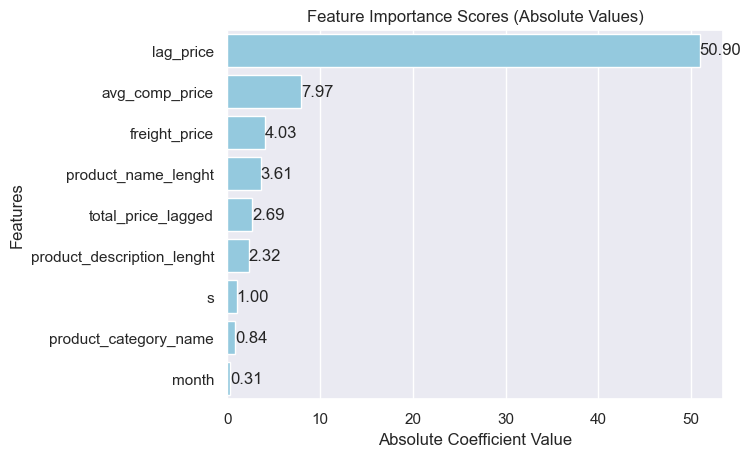

In [112]:
# Plotting the Feature Scores

ax = sns.barplot(x='abs_val', y='Features', data=model_coef, color='skyblue')
ax.bar_label(ax.containers[0], fmt=lambda x: f'{x:0.2f}')

plt.title('Feature Importance Scores (Absolute Values)')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Features')
plt.show()

#### Observations:
* Removal of product_id column has reduced the scores very slightly, with the test R2 score as 0.96
* However, there no longer exists any multi-colinearity in the model now
* Lag Price is by far the most important feature when it comes to predicting the Unit Price by a huge margin, followed by the Average Competitor Price.

## Final Recommendations
1. Certain Product Categories such as <b>Console Games</b> and <b>Perfumery</b> have too few products in them, that is resulting in reduced Revenue for those Product Categories. TrendElite must explore adding more products to those Product Categories in order to optimize overall Revenue
2. Based on competitor analysis and many other factors, <b>Dynamic Pricing </b> would be the best pricing model for TrendElite, which would account for Competitor Prices, Demand, Seasonality, etc. and ajust product prices accordingly
3. The factors influencing a Products Price the most are the <b>last month price of the product, Average Competitor Price, Company's Average Freight Price, Product Name Length, Last Month Product Revenue, etc.</b>
4. Using these features, we're able to estimate the Product Price for a month pretty well using a Linear Regression Model, with the Test R Squared Metric Value as <b>0.96</b>